In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
import collections
from IPython.display import Image
from astropy.table import Table
from spec_tools import Source_present, Get_Sensitivity,Mag
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
from astropy.cosmology import Planck13 as cosmo

from glob import glob
import seaborn as sea
import os
from grizli import model as griz_model
from spec_extract import Stack
from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=0.9, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'
if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

# Get list of all objects

In [2]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

v4Ncat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                 format='ascii').to_pandas()
v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

v4N['use'] = v4Ncat['use_phot']
v4S['use'] = v4Scat['use_phot']

v4N['star'] = v4Ncat['class_star']
v4S['star'] = v4Scat['class_star']

v4N['f125'] = v4Ncat['f_F125W']
v4S['f125'] = v4Scat['f_F125W']

v4N['f160'] = v4Ncat['f_F160W']
v4S['f160'] = v4Scat['f_F160W']

filesN = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*N*/*')
filesS = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*S*/*')

allNids = [int(os.path.basename(U).replace('.1D.fits','').split('_')[1]) for U in filesN]
allSids = [int(os.path.basename(U).replace('.1D.fits','').split('_')[1]) for U in filesS]

Nids = np.array(list(set(allNids)))
Sids = np.array(list(set(allSids)))

Npresent = [U in Nids for U in v4N.id]
Spresent = [U in Sids for U in v4S.id]

v4N['grism'] = Npresent
v4S['grism'] = Spresent

In [2]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

In [7]:
morph_db.keys()

Index(['Av', 'Av_hci', 'Z', 'Z_hci', 'lmass', 'lmass_hci', 'lwa', 'lwa_hci',
       'm1', 'm10', 'm10_hci', 'm1_hci', 'm2', 'm2_hci', 'm3', 'm3_hci', 'm4',
       'm4_hci', 'm5', 'm5_hci', 'm6', 'm6_hci', 'm7', 'm7_hci', 'm8',
       'm8_hci', 'm9', 'm9_hci', 'zgrism', 'zgrism_hci', 'field', 'id', 'z_50',
       'z_50_hci', 'z_q', 'z_q_hci', 't_50', 't_50_hci', 't_q', 't_q_hci',
       'log_ssfr', 'log_ssfr_hci', 'n_f125', 'n_f160', 'Re_f125', 'Re_f160',
       'compact_A_f125', 'A_f125', 'compact_B_f125', 'B_f125',
       'compact_A_f160', 'A_f160', 'compact_B_f160', 'B_f160', 'Sigma1_f125',
       'Sigma1_f160', 'compact_Sigma1_f125', 'compact_Sigma1_f160', 'Re', 'A',
       'B', 'Sigma1', 'compact_A', 'compact_B', 'compact_Sigma1', 'n_f125_f',
       'n_f160_f', 'n', 'n_f', 'Re_f125_sig', 'Re_f160_sig', 'Re_sig'],
      dtype='object')

In [6]:
inout = np.repeat('o', len(v4N))

for i in v4N.index:
    if v4N.id[i] in morph_db.query('field == "GND"').id.values:
        inout[i] = 'i'
        
v4N['inout'] = inout


inout = np.repeat('o', len(v4S))

for i in v4S.index:
    if v4S.id[i] in morph_db.query('field == "GSD"').id.values:
        inout[i] = 'i'
        
v4S['inout'] = inout

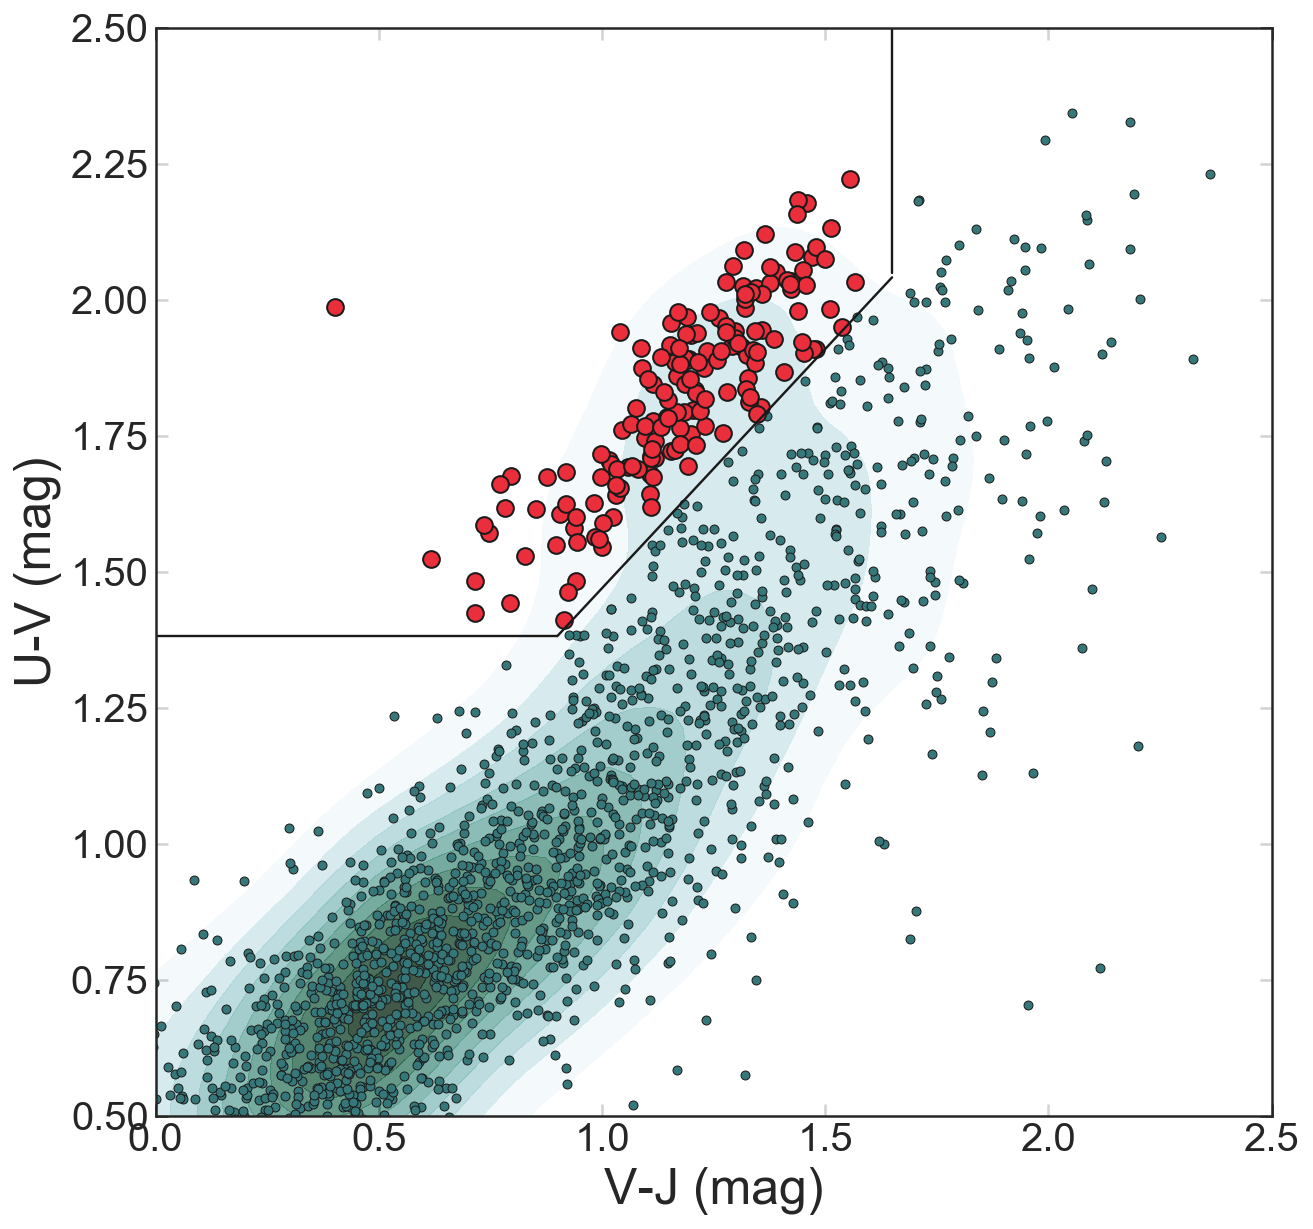

In [41]:
v4N_samp = v4N.query('mass > 10**9.5 and 0.6 < z500 < 3 and use == 1 and star < 0.8 and grism == True and inout == "i"')
v4S_samp = v4S.query('mass > 10**9.5 and 0.6 < z500 < 3 and use == 1 and star < 0.8 and grism == True and inout == "i"')

v4N_red = v4N.query('mass > 10**9.5 and 0.6 < z500 < 3 and use == 1 and star < 0.8 and grism == True')
v4S_red = v4S.query('mass > 10**9.5 and 0.6 < z500 < 3 and use == 1 and star < 0.8 and grism == True')


def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

NUV = Color(v4N_red.restU, v4N_red.restV)
NVJ = Color(v4N_red.restV, v4N_red.restJ)
SUV = Color(v4S_red.restU, v4S_red.restV)
SVJ = Color(v4S_red.restV, v4S_red.restJ)

NUV_s = Color(v4N_samp.restU, v4N_samp.restV)
NVJ_s = Color(v4N_samp.restV, v4N_samp.restJ)
SUV_s = Color(v4S_samp.restU, v4S_samp.restV)
SVJ_s = Color(v4S_samp.restV, v4S_samp.restJ)


SQ = []
NQ = []
Ssf = []
Nsf = []
for i in NUV.index:
    if NUV[i]>=0.88*NVJ[i]+0.59 and NUV[i]>1.382 and NVJ[i]<1.65:
        NQ.append(i)
    else:
        Nsf.append(i)
    
for i in SUV.index:
    if SUV[i]>=0.88*SVJ[i]+0.59 and SUV[i]>1.382 and SVJ[i]<1.65:
        SQ.append(i)
    else:
        Ssf.append(i)

SQ_s = []
NQ_s = []
Ssf_s = []
Nsf_s = []
for i in NUV_s.index:
    if NUV_s[i]>=0.88*NVJ_s[i]+0.59 and NUV_s[i]>1.382 and NVJ_s[i]<1.65:
        NQ_s.append(i)
    else:
        Nsf_s.append(i)
    
for i in SUV_s.index:
    if SUV_s[i]>=0.88*SVJ_s[i]+0.59 and SUV_s[i]>1.382 and SVJ_s[i]<1.65:
        SQ_s.append(i)
    else:
        Ssf_s.append(i)

allVJ = np.append(np.append(SVJ[Ssf], NVJ[Nsf]), np.append(SVJ_s[SQ_s], NVJ_s[NQ_s]))
allUV = np.append(np.append(SUV[Ssf], NUV[Nsf]), np.append(SUV_s[SQ_s], NUV_s[NQ_s]))
        
        
plt.figure(figsize=[10,10])
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0.1, light=1.1, as_cmap=True)

sea.kdeplot(allVJ, allUV,n_levels = 12,alpha = .8,shade=True,kernel= 'epa',zorder=1, cmap = cmap)

plt.scatter(SVJ[Ssf], SUV[Ssf],marker = 'o', s=20, color = '#36787A',linewidths=0.5, edgecolors='k')
plt.scatter(NVJ[Nsf], NUV[Nsf],marker = 'o', s=20, color = '#36787A',linewidths=0.5, edgecolors='k')

plt.scatter(SVJ_s[SQ_s], SUV_s[SQ_s],marker = 'o', s=70, color = '#EA2E3B',linewidths=1, edgecolors='k')
plt.scatter(NVJ_s[NQ_s], NUV_s[NQ_s],marker = 'o', s=70, color = '#EA2E3B',linewidths=1, edgecolors='k')

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

plt.xlabel('V-J (mag)', fontsize=25)
plt.ylabel('U-V (mag)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.savefig('../plots/presentation_plots/uvj.png', bbox_inches = 'tight')

In [10]:
len(SQ) +  len(NQ) , (len(SQ) +  len(NQ)) / 10

(227, 22.7)

In [11]:
len(SQ) +  len(NQ) , (len(SQ) +  len(NQ)) / 12

(227, 18.916666666666668)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


[0, 2.5, 0.5, 2.5]

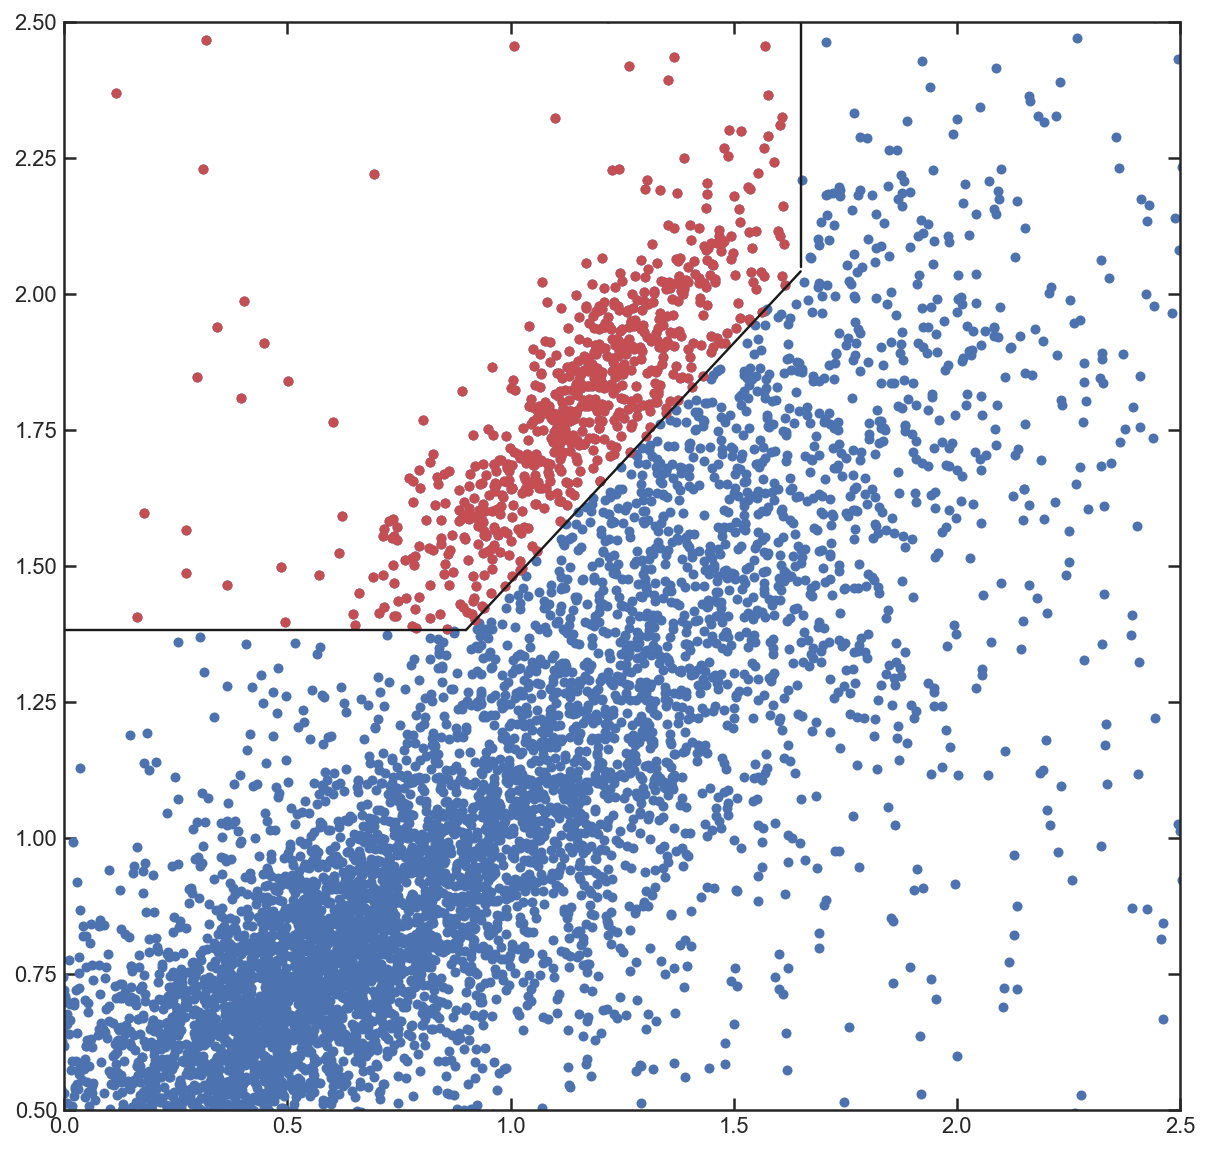

In [22]:
v4N_red = v4N.query('mass > 10**9.5 and 0.7 < z500 < 2.5 and use == 1 and star < 0.8')
v4S_red = v4S.query('mass > 10**9.5 and 0.7 < z500 < 2.5 and use == 1 and star < 0.8')

def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

NUV = Color(v4N_red.restU, v4N_red.restV)
NVJ = Color(v4N_red.restV, v4N_red.restJ)

SUV = Color(v4S_red.restU, v4S_red.restV)
SVJ = Color(v4S_red.restV, v4S_red.restJ)

SQ = []
NQ = []
Ssf = []
Nsf = []
for i in NUV.index:
    if NUV[i]>=0.88*NVJ[i]+0.59 and NUV[i]>1.382 and NVJ[i]<1.65:
        NQ.append(i)
    else:
        Nsf.append(i)
    
for i in SUV.index:
    if SUV[i]>=0.88*SVJ[i]+0.59 and SUV[i]>1.382 and SVJ[i]<1.65:
        SQ.append(i)
    else:
        Ssf.append(i)
        
plt.figure(figsize=[10,10])
plt.plot(SVJ, SUV,'bo',ms=4)
plt.plot(NVJ, NUV,'bo',ms=4)

plt.plot(SVJ[SQ], SUV[SQ],'ro',ms=4)
plt.plot(NVJ[NQ], NUV[NQ],'ro',ms=4)

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

In [99]:
GS_new = pd.DataFrame({ 'id' : v4S.id[SQ].values , 'ra' : v4S.ra[SQ].values, 'dec' : v4S.dec[SQ].values, 'zphot' : v4S.z500[SQ].values
                       , 'f125': v4S.f125[SQ].values, 'f160': v4S.f160[SQ].values, 'mass' : v4S.mass[SQ].values,
                      'zerr' : (v4S.z840[SQ].values - v4S.z160[SQ].values) / (1 + v4S.z500[SQ].values) / 2})
GN_new = pd.DataFrame({ 'id' : v4N.id[NQ].values , 'ra' : v4N.ra[NQ].values, 'dec' : v4N.dec[NQ].values, 'zphot' : v4N.z500[NQ].values
                       , 'f125': v4N.f125[NQ].values, 'f160': v4N.f160[NQ].values, 'mass' : v4N.mass[NQ].values,
                      'zerr' : (v4N.z840[NQ].values - v4N.z160[NQ].values) / (1 + v4N.z500[NQ].values) / 2})

# remove AGN

In [6]:
GSD_cat = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat',format='ascii').to_pandas()
GND_cat = Table.read('/Users/vestrada/Desktop/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat',format='ascii').to_pandas()

agn_ra=fits.open('../../../Clear_data/AGN_catalog/tbl04.fits')[1].data['GOODSS_RA']
agn_dec=fits.open('../../../Clear_data/AGN_catalog/tbl04.fits')[1].data['GOODSS_DEC']

In [5]:
SF_df = pd.read_pickle('../Casey_data/SF_fits/SF_db.pkl')

In [7]:
def Match_agn(gal_ra, gal_dec, agn_ra, agn_dec):
    r = (1. / 60 / 60) * 0.5    
    in_out = np.repeat('---',len(gal_ra))          
    for i in range(len(gal_ra)):
        cosr = np.sin(np.radians(gal_dec[i])) * np.sin(np.radians(agn_dec)) + np.cos(np.radians(gal_dec[i]))\
                * np.cos(np.radians(agn_dec)) * np.cos(np.radians(gal_ra[i]) - np.radians(agn_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
        for ii in range(len(rad)):
            if rad[ii] < r:
                in_out[i]= 'AGN'
    return in_out

In [9]:
Sra = []
Sdec = []
Nra = []
Ndec = []

for i in GS_new.index:
    Sra.append(GSD_cat.query('id == {0}'.format(GS_new.id[i])).ra.values[0])
    Sdec.append(GSD_cat.query('id == {0}'.format(GS_new.id[i])).dec.values[0])     

for i in GN_new.index:
    Nra.append(GND_cat.query('id == {0}'.format(GN_new.id[i])).ra.values[0])
    Ndec.append(GND_cat.query('id == {0}'.format(GN_new.id[i])).dec.values[0])   

In [10]:
south_agn = Match_agn(Sra,Sdec,agn_ra,agn_dec)

In [11]:
south_agn

array(['---', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', '---', '---', 'AGN', '---', 'AGN', '---', '---', '---',
       '---', '---', '---', 'AGN', 'AGN', '---', '---', '---', '---',
       '---', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', '---', '---', '---', '---', 'AGN', '---', '---', '---',
       '---', '---', '---', '---', '---', 'AGN', '---', '---', 'AGN',
       '---', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', 'AGN', '---', '---', 'AGN', '---', '---', '---', '---',
       '---', 'AGN', '---', '---', '---', '---', '---', '---', 'AGN',
       '---', '---', '---', '---', '---', '---', '---', 'AGN', '---',
       '---', '---', '---', '---', '---', '---', '---', 'AGN', '---',
       'AGN', 'AGN', '---', '---', '---', '---', '---', '---', 'AGN',
       '---', '---',

In [12]:
n_agn_cat=Table.read('../../../Clear_data/AGN_catalog/apjs523032t3_mrt.txt',format='ascii')

In [13]:
RA=np.array([n_agn_cat['RAh'].data, n_agn_cat['RAm'].data,n_agn_cat['RAs'].data]).T
DEC=np.array([n_agn_cat['DEd'].data,n_agn_cat['DEm'].data,n_agn_cat['DEs'].data]).T

def Convert_RA_DEC_to_deg(ra,dec):
    R=15*(ra[0]+ra[1]/60.+ra[2]/3600.)
    D=dec[0]+dec[1]/60.+dec[2]/3600.
    return R,D

nra_agn,ndec_agn=np.zeros([2,len(RA)])

for i in range(len(RA)):
    nra_agn[i],ndec_agn[i]=Convert_RA_DEC_to_deg(RA[i],DEC[i])

In [14]:
north_agn = Match_agn(Nra,Ndec,nra_agn,ndec_agn)

In [15]:
north_agn

array(['---', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', '---', '---', '---', '---', '---', 'AGN', '---', '---',
       '---', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', '---', '---', '---', '---', '---', 'AGN', '---', '---',
       '---', '---', '---', '---', 'AGN', '---', '---', '---', '---',
       '---', '---', '---', '---', '---', '---', '---', '---', 'AGN',
       'AGN', '---', '---', '---', '---', '---', '---', '---', '---',
       'AGN', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', '---', 'AGN', '---', '---', 'AGN', '---', 'AGN', 'AGN',
       '---', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', '---', '---', '---', '---', '---', '---', '---', '---',
       '---', '---',

In [100]:
GS_new['AGN'] = south_agn
GN_new['AGN'] = north_agn

In [17]:
SF_df.to_pickle('../Casey_data/SF_db.pkl')

In [101]:
GS_new = GS_new.query('AGN != "AGN"')
GN_new = GN_new.query('AGN != "AGN"')

In [102]:
len(GS_new), len(GN_new)

(337, 315)

In [38]:
morph_db = pd.read_pickle('../dataframes/morphology.pkl')
mdb = morph_db.query('AGN != "AGN" ')

In [54]:
GSnew = []
GNnew = []

for i in GS_new.index:
    oldsamp = False
    for ii in mdb.index:
        if GS_new.id[i] == mdb.id[ii] and mdb.field[ii] == 'GSD':
            oldsamp = True
    if oldsamp: 
        GSnew.append('old')
    else:
        GSnew.append('new')
            
            
for i in GN_new.index:
    oldsamp = False
    for ii in mdb.index:
        if GN_new.id[i] == mdb.id[ii] and mdb.field[ii] == 'GND':
            oldsamp = True
    if oldsamp: 
        GNnew.append('old')
    else:
        GNnew.append('new')

In [55]:
GS_new['new'] = GSnew
GN_new['new'] = GNnew

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [60]:
GN_new = GN_new.query('new == "new"')
GS_new = GS_new.query('new == "new"')

In [61]:
len(GS_new), len(GN_new)

(53, 65)

In [103]:
GS_new.to_pickle('../dataframes/galaxy_frames/GS_3dhst.pkl')
GN_new.to_pickle('../dataframes/galaxy_frames/GN_3dhst.pkl')

In [22]:
select.to_pickle('../spec_files/section.pkl')

In [46]:
GS_samp['X_AGN'] = south_agn
GN_samp['X_AGN'] = north_agn

In [50]:
GN_samp.query('X_AGN == "AGN"')

dec     id          ra     zphot X_AGN
16  62.219797  15490  189.231035  0.922680   AGN
19  62.220373  15976  189.140654  2.421521   AGN
24  62.227507  17194  189.160390  0.992574   AGN
54  62.258077  23631  189.193273  0.821487   AGN

In [102]:
GS_samp.to_pickle('../dataframes/galaxy_frames/GS_cnd.pkl')
GN_samp.to_pickle('../dataframes/galaxy_frames/GN_cnd.pkl')

## Get SNR

In [89]:

def Sig_int(er):
    sig = np.zeros(len(er)-1)
    
    for i in range(len(er)-1):
        sig[i] = np.sqrt(er[i]**2 + er[i+1]**2 )
    
    return np.sum((1/2)*sig)

def SN(w, f, e, wmin, wmax):
    
    IDx = [U for U in range(len(w)) if wmin < w[U] < wmax]
    
    return np.trapz(f[IDx])/ Sig_int(e[IDx])

def SN_full(Bw, Bf, Be, Rw, Rf, Re, Bmin, Bmax, Rmin, Rmax):
    
    IDb = [U for U in range(len(Bw)) if Bmin < Bw[U] < Bmax]
    IDr = [U for U in range(len(Rw)) if Rmin < Rw[U] < Rmax]
    
    return np.trapz(np.append(Bf[IDb],Rf[IDr]))/ Sig_int(np.append(Be[IDb],Re[IDr]))

def Extract_spec(Field, galaxy_id):
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{0}*/*{1}*'.format(Field, galaxy_id))

    Bwv, Bfl, Ber, Bft, Bln, Bct = [[],[],[],[],[],[]]

    Rwv, Rfl, Rer, Rft, Rln, Rct = [[],[],[],[],[],[]]

    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])

        try:
            Bwv.append(np.array(dat['G102'].data['wave']).T)
            Bfl.append(np.array(dat['G102'].data['flux']).T)
            Ber.append(np.array(dat['G102'].data['err']).T)
            Bft.append(np.array(dat['G102'].data['flat']).T)
            Bln.append(np.array(dat['G102'].data['line']).T)
            Bct.append(np.array(dat['G102'].data['cont']).T)

        except:
            u='dummy'
            
        try:
            Rwv.append(np.array(dat['G141'].data['wave']).T)
            Rfl.append(np.array(dat['G141'].data['flux']).T)
            Rer.append(np.array(dat['G141'].data['err']).T)
            Rft.append(np.array(dat['G141'].data['flat']).T)
            Rln.append(np.array(dat['G141'].data['line']).T)
            Rct.append(np.array(dat['G141'].data['cont']).T)

        except:
            u='dummy'
            
    if len(Bwv) > 0:                
        SBW, SBF, SBE, SBT, SBL, SBC = Stack(Bwv, Bfl, Ber, Bft, Bln, Bct)
    
        SBW = SBW[SBF**2 > 0]
        SBE = SBE[SBF**2 > 0]
        SBF = SBF[SBF**2 > 0]
        SNB = SN(SBW, SBF, SBE, min(SBW), max(SBW))
    else:
        SNB = 0
    
    if len(Rwv) > 0:     
        SRW, SRF, SRE, SRT, SRL, SRC = Stack(Rwv, Rfl, Rer, Rft, Rln, Rct)

        SRW = SRW[SRF**2 > 0]
        SRE = SRE[SRF**2 > 0]
        SRF = SRF[SRF**2 > 0]
        SNR = SN(SRW, SRF, SRE, min(SRW), max(SRW))
    else:
        SNR = 0
    
    if SNR == 0:
        return SNB
    if SNB == 0:
        return SNR
    if SNB != 0 and SNR != 0:
        return (SNB + SNR) / 2
    if SNR == 0 and SNB == 0:
        return 0


In [90]:
S_SNR = []
for i in GS_samp.index:
    S_SNR.append(Extract_spec('S', GS_samp.id[i]))
    
N_SNR = []
for i in GN_samp.index:
    N_SNR.append(Extract_spec('N', GN_samp.id[i]))

/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:41: RuntimeWarning: divide by zero encountered in power
  weigrid = errgrid ** (-2)
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:48: RuntimeWarning: invalid value encountered in double_scalars
  stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:49: RuntimeWarning: invalid value encountered in double_scalars
  stack_flat[i] = np.sum(fltgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:50: RuntimeWarning: invalid value encountered in double_scalars
  stack_line[i] = np.sum(linegrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:51: RuntimeWarning: invalid value encountered in double_scalars
  stack_cont[i] = np.sum(contgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_fiel

In [100]:
GS_qs = GS_samp.query('SNR >= 10')
GN_qs = GN_samp.query('SNR >= 10')

In [101]:
GS_qs.to_pickle('../dataframes/galaxy_frames/GS_snr.pkl')
GN_qs.to_pickle('../dataframes/galaxy_frames/GN_snr.pkl')

In [83]:
glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*S*/*19872*')

['/Volumes/Vince_CLEAR/RELEASE_v2.1.0/GS4/GS4_19872.1D.fits']

In [84]:
dat = fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/GS4/GS4_19872.1D.fits')
Bwv = np.array(dat['G102'].data['wave']).T
Bfl = np.array(dat['G102'].data['flux']).T
Ber = np.array(dat['G102'].data['err']).T
Bft = np.array(dat['G102'].data['flat']).T
Bln = np.array(dat['G102'].data['line']).T
Bct = np.array(dat['G102'].data['cont']).T

Rwv = np.array(dat['G141'].data['wave']).T
Rfl = np.array(dat['G141'].data['flux']).T
Rer = np.array(dat['G141'].data['err']).T
Rft = np.array(dat['G141'].data['flat']).T
Rln = np.array(dat['G141'].data['line']).T
Rct = np.array(dat['G141'].data['cont']).T

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


<ErrorbarContainer object of 3 artists>

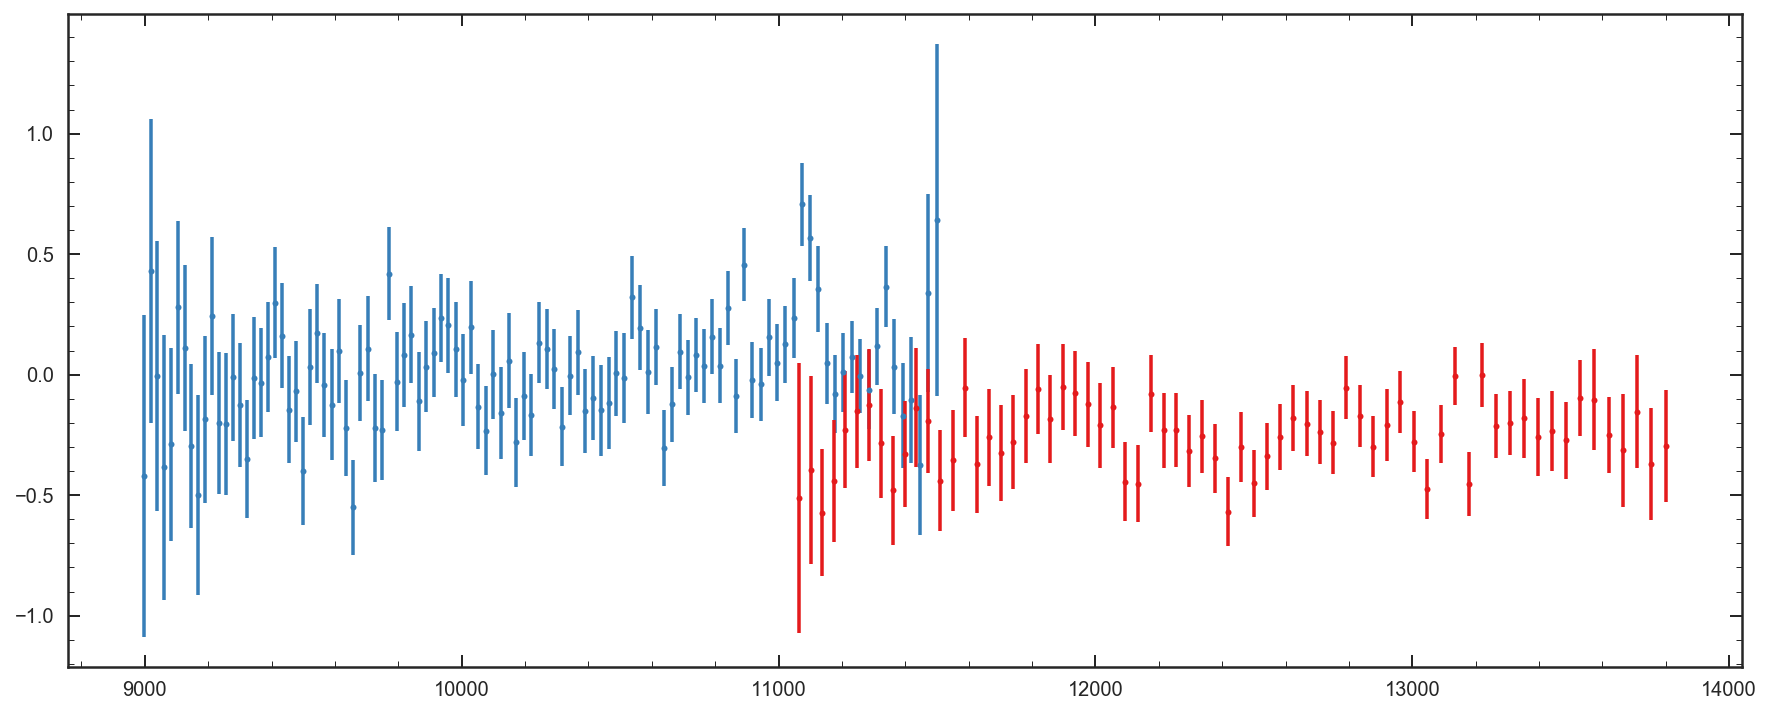

In [86]:
plt.figure(figsize=[15,6])
plt.errorbar(Bwv ,Bfl / Bft *1E18, Ber / Bft*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(Rwv,Rfl / Rft *1E18, Rer / Rft*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')

In [88]:
SN(Bwv, Bfl, Ber, min(Bwv), max(Bwv)), SN(Rwv, Rfl, Rer, min(Rwv), max(Rwv))

(0.13376803802762502, -1.990234851149446)

<ErrorbarContainer object of 3 artists>

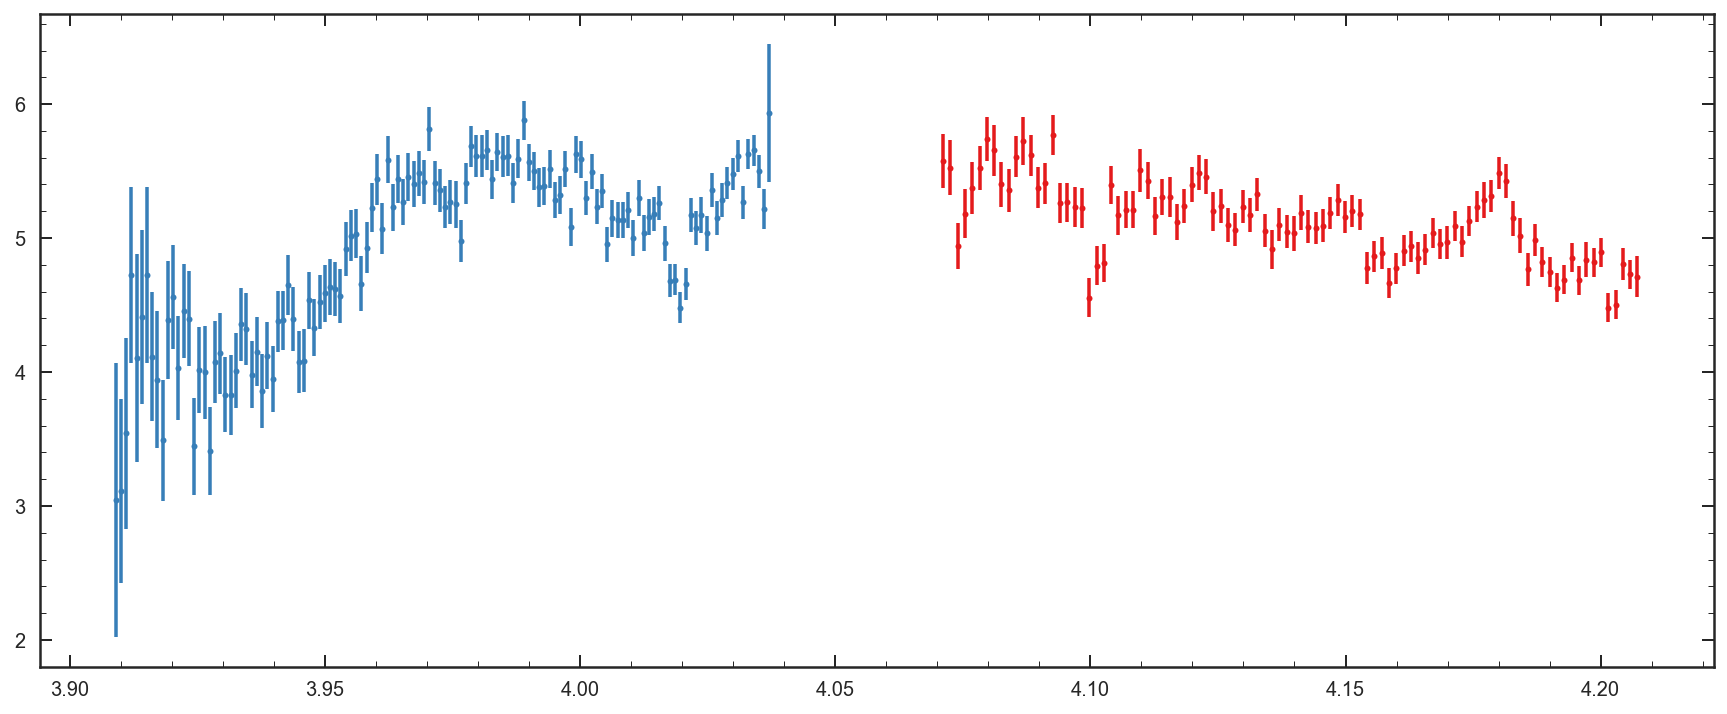

In [65]:
plt.figure(figsize=[15,6])
plt.errorbar(np.log10(spec[0]),spec[1]*1E18,spec[2]*1E18,
                linestyle='None', marker='o', markersize=3, color='#377eb8',zorder = 2, label = 'CLEAR G102')
plt.errorbar(np.log10(spec[3]),spec[4]*1E18,spec[5]*1E18,
                linestyle='None', marker='o', markersize=3, color='#e41a1c',zorder = 2, label = '3D-HST G141')

In [104]:
def Extract_spec(Field, galaxy_id):
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{0}*/*{1}*'.format(Field, galaxy_id))

    Bwv, Bfl, Ber, Bft, Bln, Bct = [[],[],[],[],[],[]]

    Rwv, Rfl, Rer, Rft, Rln, Rct = [[],[],[],[],[],[]]

    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])

        try:
            Bwv.append(np.array(dat['G102'].data['wave']).T)
            Bfl.append(np.array(dat['G102'].data['flux']).T)
            Ber.append(np.array(dat['G102'].data['err']).T)
            Bft.append(np.array(dat['G102'].data['flat']).T)
            Bln.append(np.array(dat['G102'].data['line']).T)
            Bct.append(np.array(dat['G102'].data['cont']).T)

        except:
            print('no g102')

        try:
            Rwv.append(np.array(dat['G141'].data['wave']).T)
            Rfl.append(np.array(dat['G141'].data['flux']).T)
            Rer.append(np.array(dat['G141'].data['err']).T)
            Rft.append(np.array(dat['G141'].data['flat']).T)
            Rln.append(np.array(dat['G141'].data['line']).T)
            Rct.append(np.array(dat['G141'].data['cont']).T)

        except:
            print('no g141')

    if len(Bwv) > 0:                
        SBW, SBF, SBE, SBT, SBL, SBC = Stack(Bwv, Bfl, Ber, Bft, Bln, Bct)
        np.save('../spec_files/G{0}D_{1}_g102'.format(Field, galaxy_id),[SBW, SBF, SBE, SBT, SBL, SBC])


    if len(Rwv) > 0:     
        SRW, SRF, SRE, SRT, SRL, SRC = Stack(Rwv, Rfl, Rer, Rft, Rln, Rct)
        np.save('../spec_files/G{0}D_{1}_g141'.format(Field, galaxy_id),[SRW, SRF, SRE, SRT, SRL, SRC])

for i in GS_qs.index:
    Extract_spec('S', GS_qs.id[i])
    
for i in GN_qs.index:
    Extract_spec('N', GN_qs.id[i])

no g102


/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:41: RuntimeWarning: divide by zero encountered in power
  weigrid = errgrid ** (-2)
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:48: RuntimeWarning: invalid value encountered in double_scalars
  stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:49: RuntimeWarning: invalid value encountered in double_scalars
  stack_flat[i] = np.sum(fltgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:50: RuntimeWarning: invalid value encountered in double_scalars
  stack_line[i] = np.sum(linegrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:51: RuntimeWarning: invalid value encountered in double_scalars
  stack_cont[i] = np.sum(contgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_fiel

no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g102
no g141
no g141
no g102
no g102
no g102
no g102
no g102
no g141
no g141
no g102
no g141
no g141
no g141
no g141
no g102
no g141


# load catlog

In [5]:
def Get_rf_info(field,subfield):

    U = Table.read('/Users/Vince.ec/eazy-photoz/{0}/products/{1}_out.153.rf'.format(field,subfield), format = 'ascii')
    V = Table.read('/Users/Vince.ec/eazy-photoz/{0}/products/{1}_out.155.rf'.format(field,subfield), format = 'ascii')
    J = Table.read('/Users/Vince.ec/eazy-photoz/{0}/products/{1}_out.161.rf'.format(field,subfield), format = 'ascii')
    fast = Table.read('/Users/Vince.ec/FAST_v1.0/GS/products/{0}.fout'.format(subfield), format = 'ascii')

    ids = []; z=[]; z16=[]; z84=[]; lmass = []
    u=[];v=[];j=[]
    for i in range(len(U)):
        ids.append(U['id'][i])
        z.append(U['z'][i])
        u.append(U['L153'][i])
        v.append(V['L155'][i])    
        j.append(J['L161'][i])
        
        if len(str(U['id'][i])) < 5:
            gid = '0' + str(U['id'][i])
        else:
            gid = str(U['id'][i])

        dat = fits.open(glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/{0}/*/Prep/{0}_{1}.full.fits'.format(subfield,gid))[0])
        
        z16.append(dat[2].header['Z16'])
        z84.append(dat[2].header['Z84'])

        lmass.append(fast['col7'][i])
    
    ids=np.array(ids)
    z=np.array(z)
    z16=np.array(z16)
    z84=np.array(z84)
    lmass=np.array(lmass)
    u=np.array(u)
    v=np.array(v)
    j=np.array(j)
    
    return ids, z, z16, z84, lmass, u, v, j
#     return ids, z, lmass, u, v, j


In [6]:
flds = ['GN1','GN2','GN3','GN4','GN5','GN7']

ids = []; z=[]; z16=[]; z84=[]; lmass = []
u=[];v=[];j=[]; fid=[]

for i in flds:
    I,Z,Z16,Z84,L,U,V,J = Get_rf_info('GN',i)
    ids.extend(I)
    z.extend(Z)
    z16.extend(Z16)
    z84.extend(Z84)
    lmass.extend(L)
    u.extend(U)
    v.extend(V)
    j.extend(J)
    fid.extend(np.repeat(i,len(U)))

N_vals = pd.DataFrame({'id':ids,'field':fid,'z50':z,'z16':z16,'z84':z84,'lmass':lmass,'U':u,'V':v,'J':j})

In [7]:
flds = ['GS1','GS2','GS3','GS5']

ids = []; z=[]; z16=[]; z84=[]; lmass = []
u=[];v=[];j=[]; fid=[]

for i in flds:
    I,Z,Z16,Z84,L,U,V,J = Get_rf_info('GS',i)
    ids.extend(I)
    z.extend(Z)
    z16.extend(Z16)
    z84.extend(Z84)
    lmass.extend(L)
    u.extend(U)
    v.extend(V)
    j.extend(J)
    fid.extend(np.repeat(i,len(U)))

S_vals = pd.DataFrame({'id':ids,'field':fid,'z50':z,'z16':z16,'z84':z84,'lmass':lmass,'U':u,'V':v,'J':j})

In [8]:
N_vals = N_vals[['field','id','z50','z16','z84','lmass','U','V','J']]
S_vals = S_vals[['field','id','z50','z16','z84','lmass','U','V','J']]

In [9]:
N_vals.to_pickle('../dataframes/GN_uvj_z_grism_v2.pkl')
S_vals.to_pickle('../dataframes/GS_uvj_z_grism_v2.pkl')

In [99]:
ids,z,lmass,u,v,j = Get_rf_info('GS')

S_vals = pd.DataFrame({'id':ids,'z':z,'lmass':lmass,'U':u,'V':v,'J':j})

S_vals = S_vals[['id','z','lmass','U','V','J']]

In [109]:
ids,z,lmass,u,v,j = Get_rf_info('GN')

N_vals = pd.DataFrame({'id':ids,'z':z,'lmass':lmass,'U':u,'V':v,'J':j})

N_vals = N_vals[['id','z','lmass','U','V','J']]

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


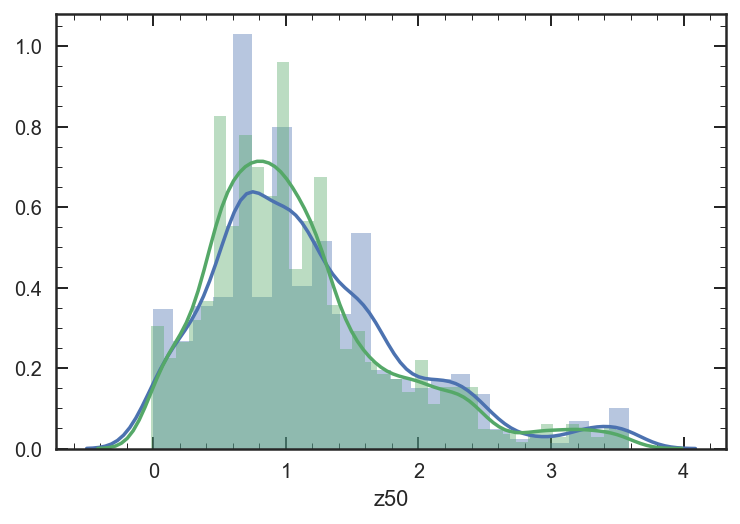

In [11]:
sea.distplot(S_vals.z50)
sea.distplot(N_vals.z50)


In [12]:
def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

N_UV = Color(N_vals.U,N_vals.V)
N_VJ = Color(N_vals.V,N_vals.J)

S_UV = Color(S_vals.U,S_vals.V)
S_VJ = Color(S_vals.V,S_vals.J)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


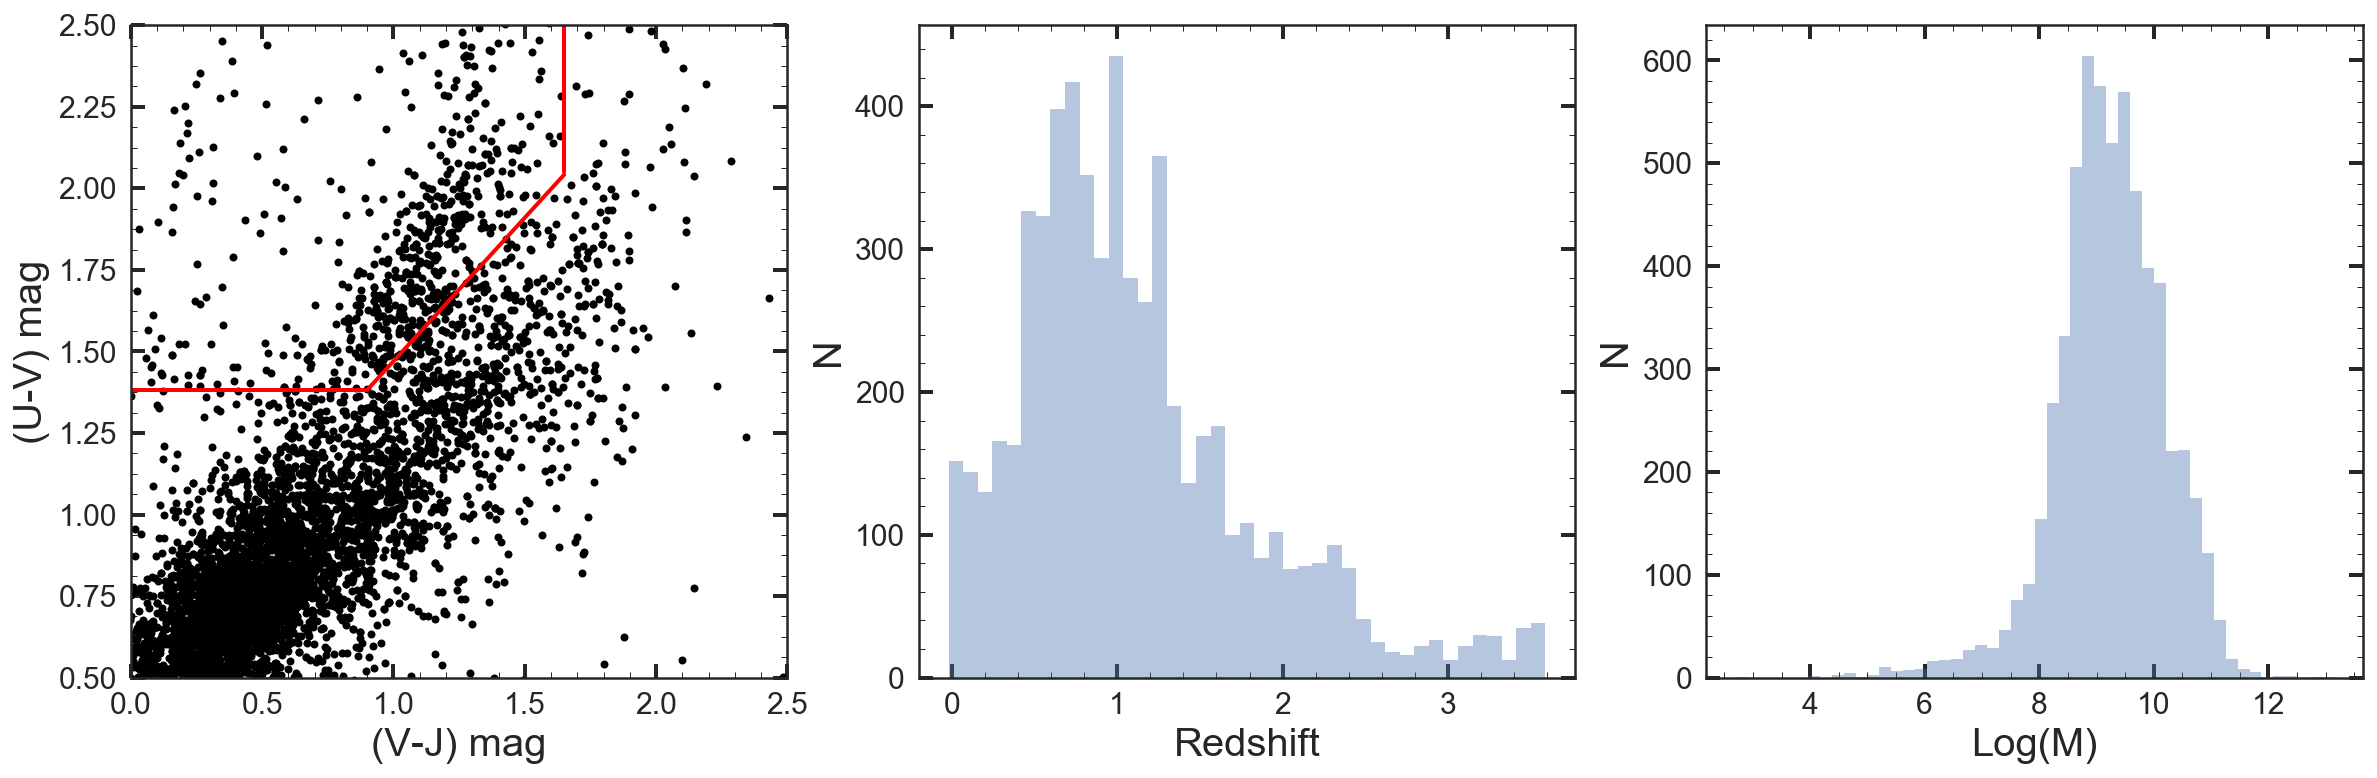

In [14]:
gs = gridspec.GridSpec(1,3)

plt.figure(figsize=[20,6])
plt.subplot(gs[0])
plt.plot(S_VJ, S_UV,'ko',ms=4)
plt.plot(N_VJ, N_UV,'ko',ms=4)

plt.plot([0,.9],[1.382,1.382],'r',lw=2)
plt.plot([1.65,1.65],[2.05,2.5],'r',lw=2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'r',lw=2)
plt.axis([0,2.5,.5,2.5])
plt.xlabel('(V-J) mag',fontsize=20)
plt.ylabel('(U-V) mag',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15,length = 7, width=2)

plt.subplot(gs[1])
sea.distplot(np.append(N_vals.z50,S_vals.z50),kde = False)
plt.xlabel('Redshift',fontsize=20)
plt.ylabel('N',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15,length = 7, width=2)

plt.subplot(gs[2])
sea.distplot(np.append(N_vals.query('lmass > 0').lmass, S_vals.query('lmass > 0').lmass),kde = False)
plt.xlabel('Log(M)',fontsize=20)
plt.ylabel('N',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15,length = 7, width=2)

# plt.savefig('../plots/uvj_mass.png',bbox_inches = 'tight')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


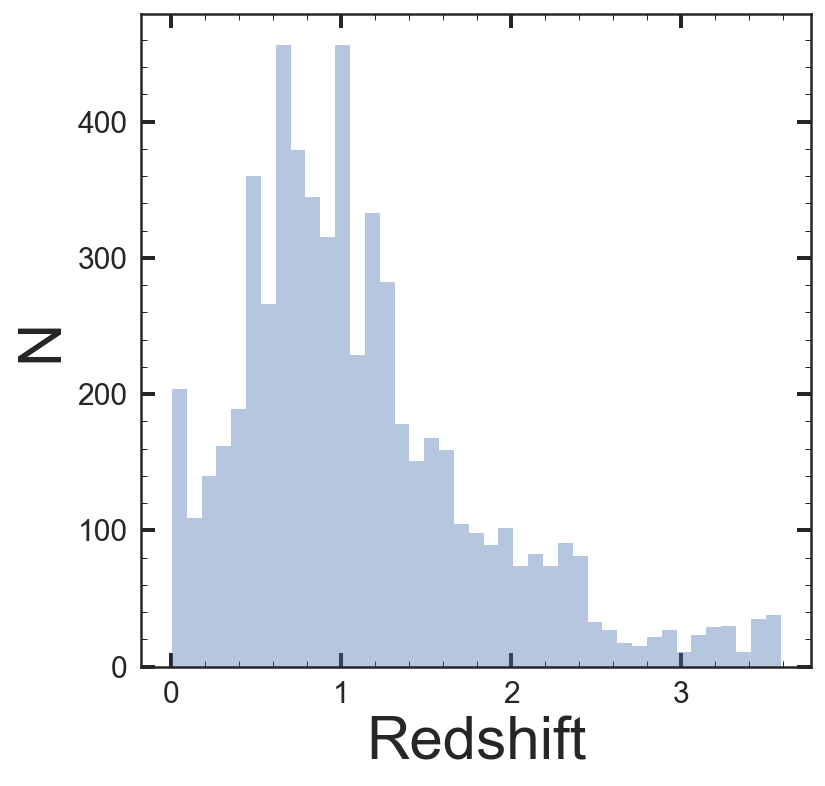

In [11]:
plt.figure(figsize=[6,6])
sea.distplot(np.append(N_vals.z50,S_vals.z50),kde = False)
plt.xlabel('Redshift',fontsize=30)
plt.ylabel('N',fontsize=30)
plt.tick_params(axis='both', which='major', labelsize=15,length = 7, width=2)
plt.savefig('../plots/z_dist.png',bbox_inches = 'tight')

In [119]:
S_vals.to_pickle('../dataframes/GS_v4.3_uvj.pkl')
N_vals.to_pickle('../dataframes/GN_v4.3_uvj.pkl')

In [12]:
N_vals

field     id      z50       z16       z84  lmass          U           V  \
0      GN1  35831  1.10728  1.104377  1.110669  10.41   7.989820   23.559600   
1      GN1  35918  1.14262  1.122759  1.156827  10.00   5.348300   12.244600   
2      GN1  35921  0.83509  0.833341  0.836873   9.59   3.181490    6.126700   
3      GN1  35933  1.10524  1.096073  1.112732   9.20   1.516420    3.060470   
4      GN1  35935  1.88363  1.866127  1.893905   9.43   1.543860    2.688370   
5      GN1  35952  0.24667  0.239639  0.254459   8.50   6.192630   13.042600   
6      GN1  35959  0.62978  0.625712  0.633074   8.63   1.889320    3.016890   
7      GN1  36067  0.03202  0.029194  0.047730   6.09   6.307880    8.241250   
8      GN1  36114  0.06014  0.058108  0.062197   8.52   3.304920   16.053500   
9      GN1  36158  0.63641  0.634602  0.638341   9.77   6.177770   18.851400   
10     GN1  36203  1.47065  1.429795  1.484439   9.11   0.936099    1.759940   
11     GN1  36243  0.78706  0.783734  0.790604   9.01   1.153910    2.786880   
12     GN1  36303  0.76363  0.763034  0.763942  10.93  26.442100  113.157000   
13     GN1  36382  1.19704  1.194034  1.199743   8.67   0.705005    1.168640   
14     GN1  36420  0.63523  0.633979  0.636466   9.89   3.920070   14.732900   
15     GN1  36456  0.73425  0.733368  0.734853  11.02  96.558200  263.537000   
16     GN1  36514  1.02085  1.019536  1.022154   9.43   2.972420    6.281790   
17     GN1  36521  0.21092  0.205140  0.225126   8.44   6.758470   14.635700   
18     GN1  36552  0.18380  0.168892  0.199217   7.68   0.597636    2.158600   
19     GN1  36556  0.65601  0.650457  0.658331   8.75   1.909920    3.934790   
20     GN1  36577  1.01844  1.017442  1.019438   9.16   3.621340    5.617550   
21     GN1  36596  0.72101  0.720539  0.721253  10.77  40.159300  128.250000   
22     GN1  36613  1.02299  1.022361  1.023616   9.81  10.687200   18.675000   
23     GN1  36623  1.06082  1.056593  1.066397   8.60   0.932663    1.479090   
24     GN1  36651  0.94410  0.941459  0.946824   8.88   0.894510    1.824440   
25     GN1  36663  2.06800  2.043256  2.079532  10.56   1.625710    5.158260   
26     GN1  36681  0.62913  0.625802  0.631800   8.79   1.256570    3.188470   
27     GN1  36717  0.53074  0.528350  0.532769   8.15   2.770210    3.613890   
28     GN1  36733  1.18779  1.182233  1.193955   9.00   1.690000    2.910570   
29     GN1  36735  0.05953  0.058193  0.060910   6.30   0.380364    0.748231   
...    ...    ...      ...       ...       ...    ...        ...         ...   
4192   GN7  23455  0.22748  0.225763  0.229295  10.09   3.330650   28.036500   
4193   GN7  23463  0.20576  0.200667  0.210537   8.09   2.001140    4.763210   
4194   GN7  23499  0.01568  0.012991  0.018658   6.41  47.859900   59.310500   
4195   GN7  23520  0.84159  0.827698  0.860623  10.49  11.529700   36.234400   
4196   GN7  23525  1.33261  1.311946  1.343473   8.96   0.919711    1.653860   
4197   GN7  23527  1.74490  1.744536  1.745268   9.25   2.732420    3.811940   
4198   GN7  23543  0.68041  0.679730  0.681116  10.07   3.185320   13.965500   
4199   GN7  23556  0.77972  0.757288  0.787207   8.58   0.980668    1.594170   
4200   GN7  23580  1.38241  1.381218  1.383559   9.08   1.949960    2.713430   
4201   GN7  23654  1.23923  1.238226  1.240284   9.53   4.625830    6.484760   
4202   GN7  23662  1.35441  1.353268  1.355520   9.64   2.791740    5.253830   
4203   GN7  23791  0.96371  0.956331  0.975860   9.18   1.358510    3.078960   
4204   GN7  23857  1.08482  1.065792  1.108775  10.28   2.315320   10.639500   
4205   GN7  23864  0.74812  0.746676  0.749489   9.23   2.869350    5.763280   
4206   GN7  23882  0.60337  0.592882  0.622421   8.97   1.644510    3.629160   
4207   GN7  23907  0.53264  0.513108  0.550622   8.19   0.381129    1.010730   
4208   GN7  23910  0.66776  0.664364  0.673059   9.37   7.338510   15.066200   
4209   GN7  23960  0.65867  0.655733  0.660942   8.19   0.636893    1.277710   
4210 

In [16]:
N_UV = Color(N_vals.query('z50 > 0.7 and lmass > 8.5').U,N_vals.query('z50 > 0.7 and lmass > 8.5').V)
N_VJ = Color(N_vals.query('z50 > 0.7 and lmass > 8.5').V,N_vals.query('z50 > 0.7 and lmass > 8.5').J)

S_UV = Color(S_vals.query('z50 > 0.7 and lmass > 8.5').U,S_vals.query('z50 > 0.7 and lmass > 8.5').V)
S_VJ = Color(S_vals.query('z50 > 0.7 and lmass > 8.5').V,S_vals.query('z50 > 0.7 and lmass > 8.5').J)

SQ=[]

NQ=[]

for i in N_UV.index:
    if N_UV[i]>=0.88*N_VJ[i]+0.59 and N_UV[i]>1.382 and N_VJ[i]<1.65:
        NQ.append(i)
        
for i in S_UV.index:
    if S_UV[i]>=0.88*S_VJ[i]+0.59 and S_UV[i]>1.382 and S_VJ[i]<1.65:
        SQ.append(i)


[0, 2.5, 0.5, 2.5]

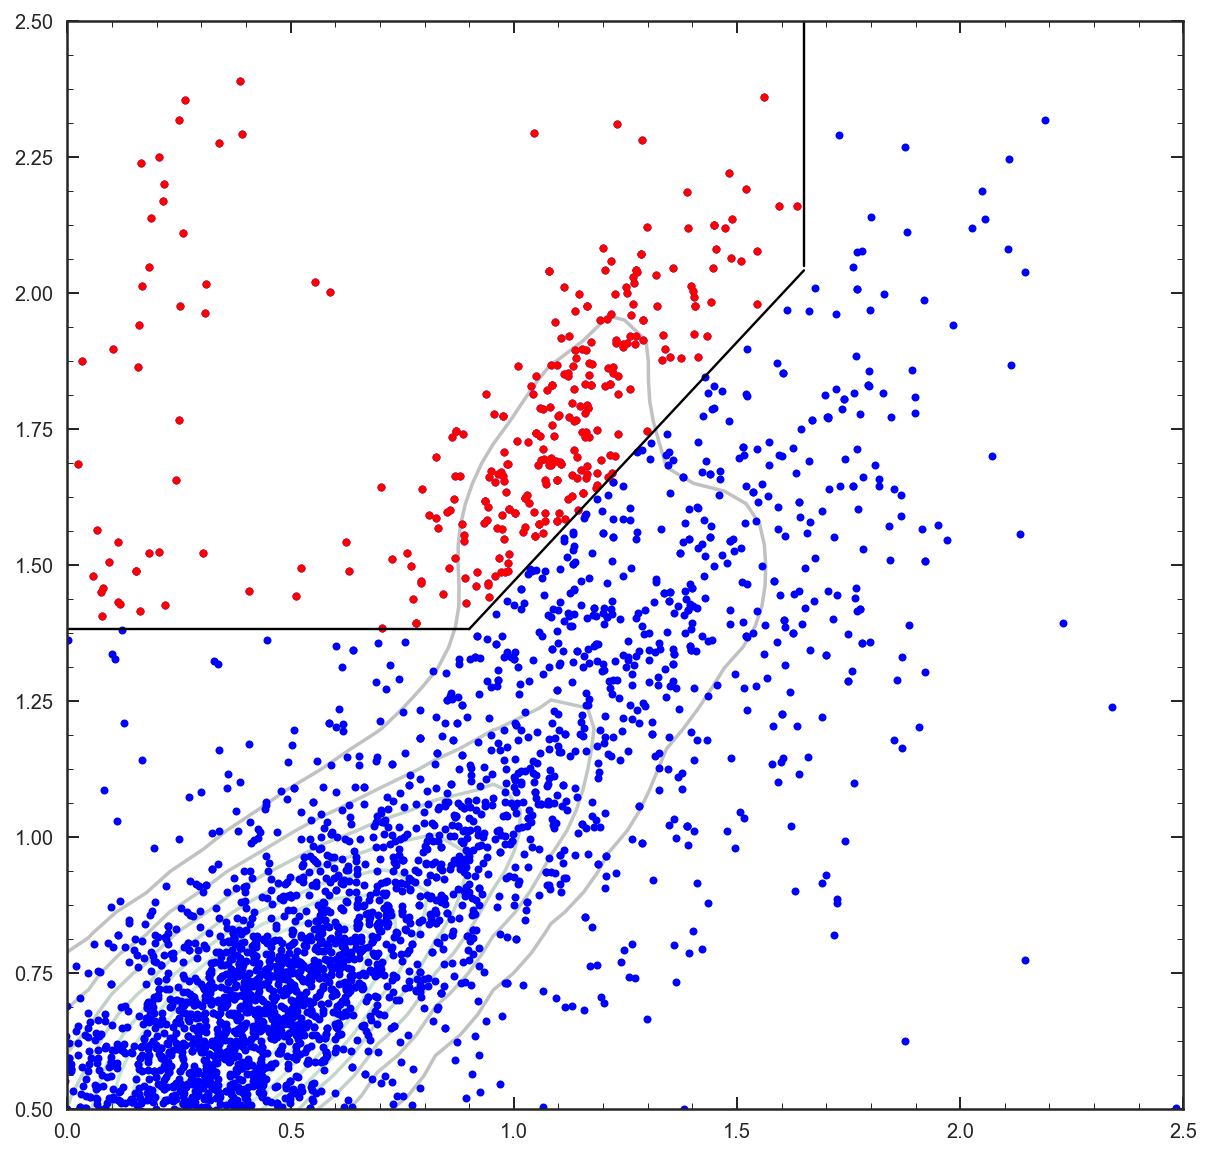

In [17]:
plt.figure(figsize=[10,10])
sea.kdeplot(np.append(S_VJ,N_VJ),np.append(S_UV,N_UV),alpha=0.3)

plt.plot(S_VJ, S_UV,'bo',ms=4)
plt.plot(N_VJ, N_UV,'bo',ms=4)

plt.plot(S_VJ[SQ], S_UV[SQ],'ro',ms=4)
plt.plot(N_VJ[NQ], N_UV[NQ],'ro',ms=4)

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

In [76]:
S_v4 = pd.read_pickle('../dataframes/GS_v4.3_uvj.pkl')
N_v4 = pd.read_pickle('../dataframes/GN_v4.3_uvj.pkl')

S_zg = pd.read_pickle('../dataframes/GS_uvj_z_grism_v2.pkl')
N_zg = pd.read_pickle('../dataframes/GN_uvj_z_grism_v2.pkl')

In [77]:
def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

N_UV_v4 = Color(N_v4.U,N_v4.V)
N_VJ_v4 = Color(N_v4.V,N_v4.J)

S_UV_v4 = Color(S_v4.U,S_v4.V)
S_VJ_v4 = Color(S_v4.V,S_v4.J)

N_UV_zg = Color(N_zg.U,N_zg.V)
N_VJ_zg = Color(N_zg.V,N_zg.J)

S_UV_zg = Color(S_zg.U,S_zg.V)
S_VJ_zg = Color(S_zg.V,S_zg.J)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


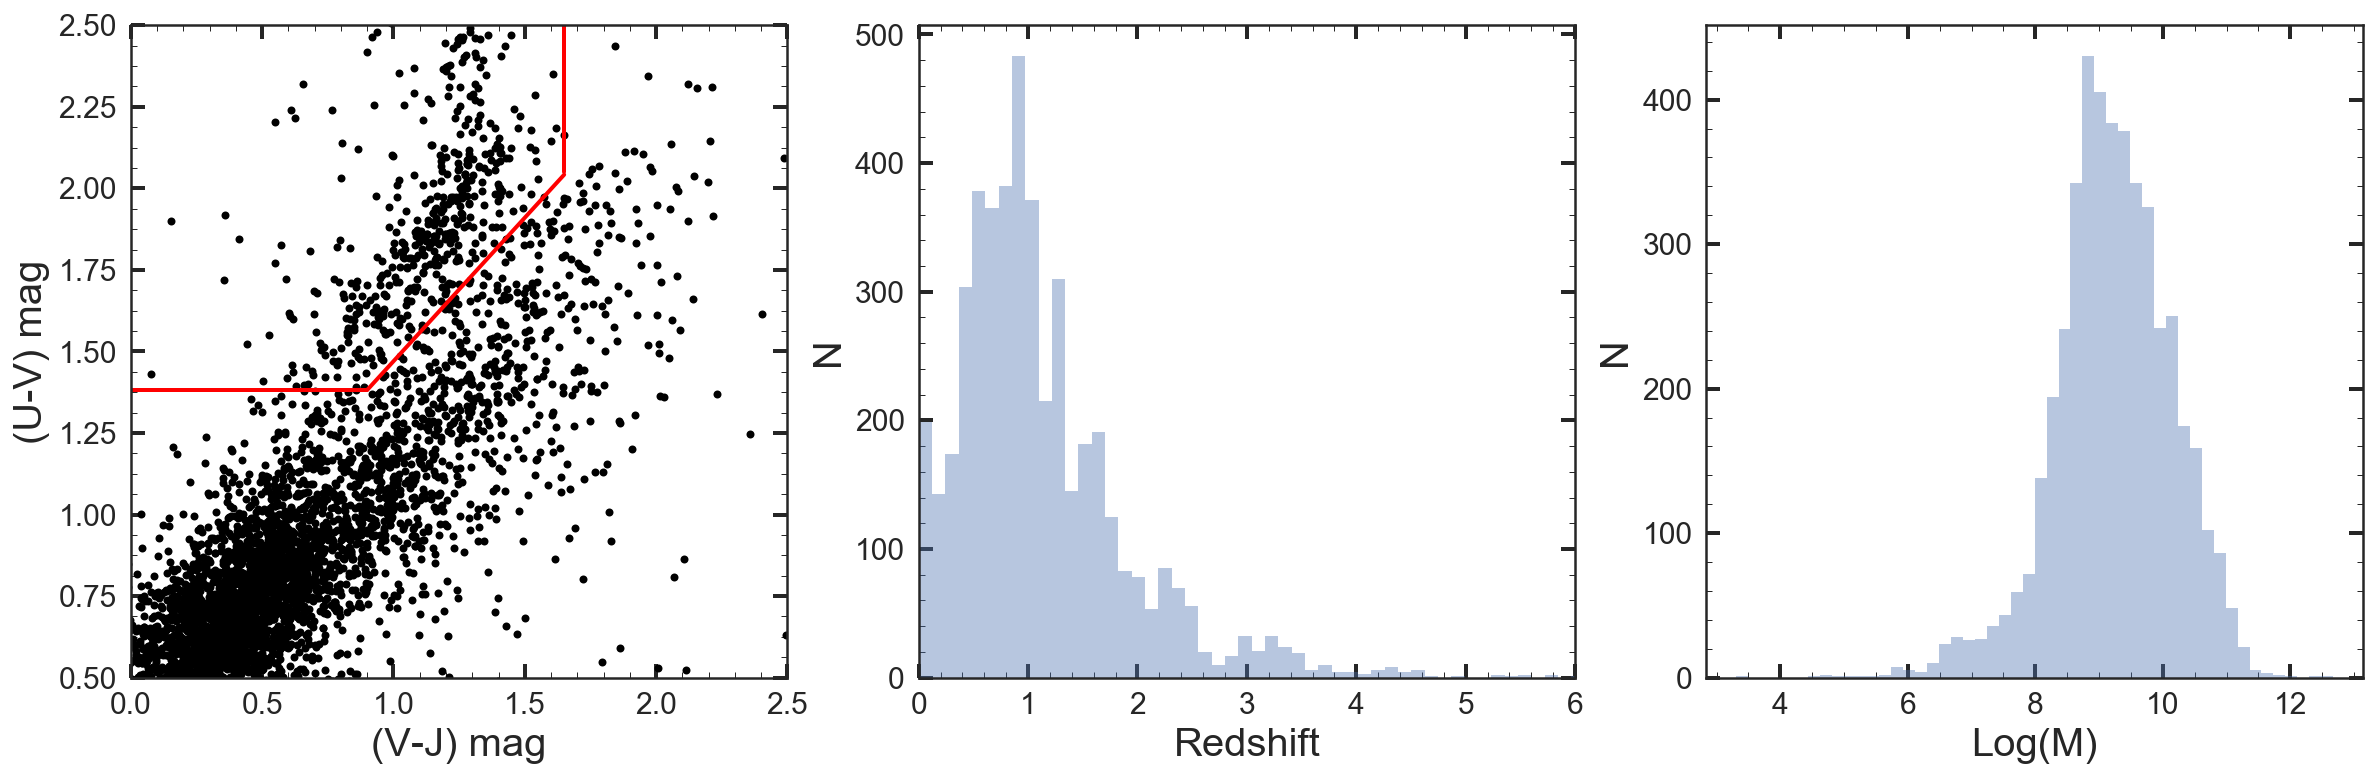

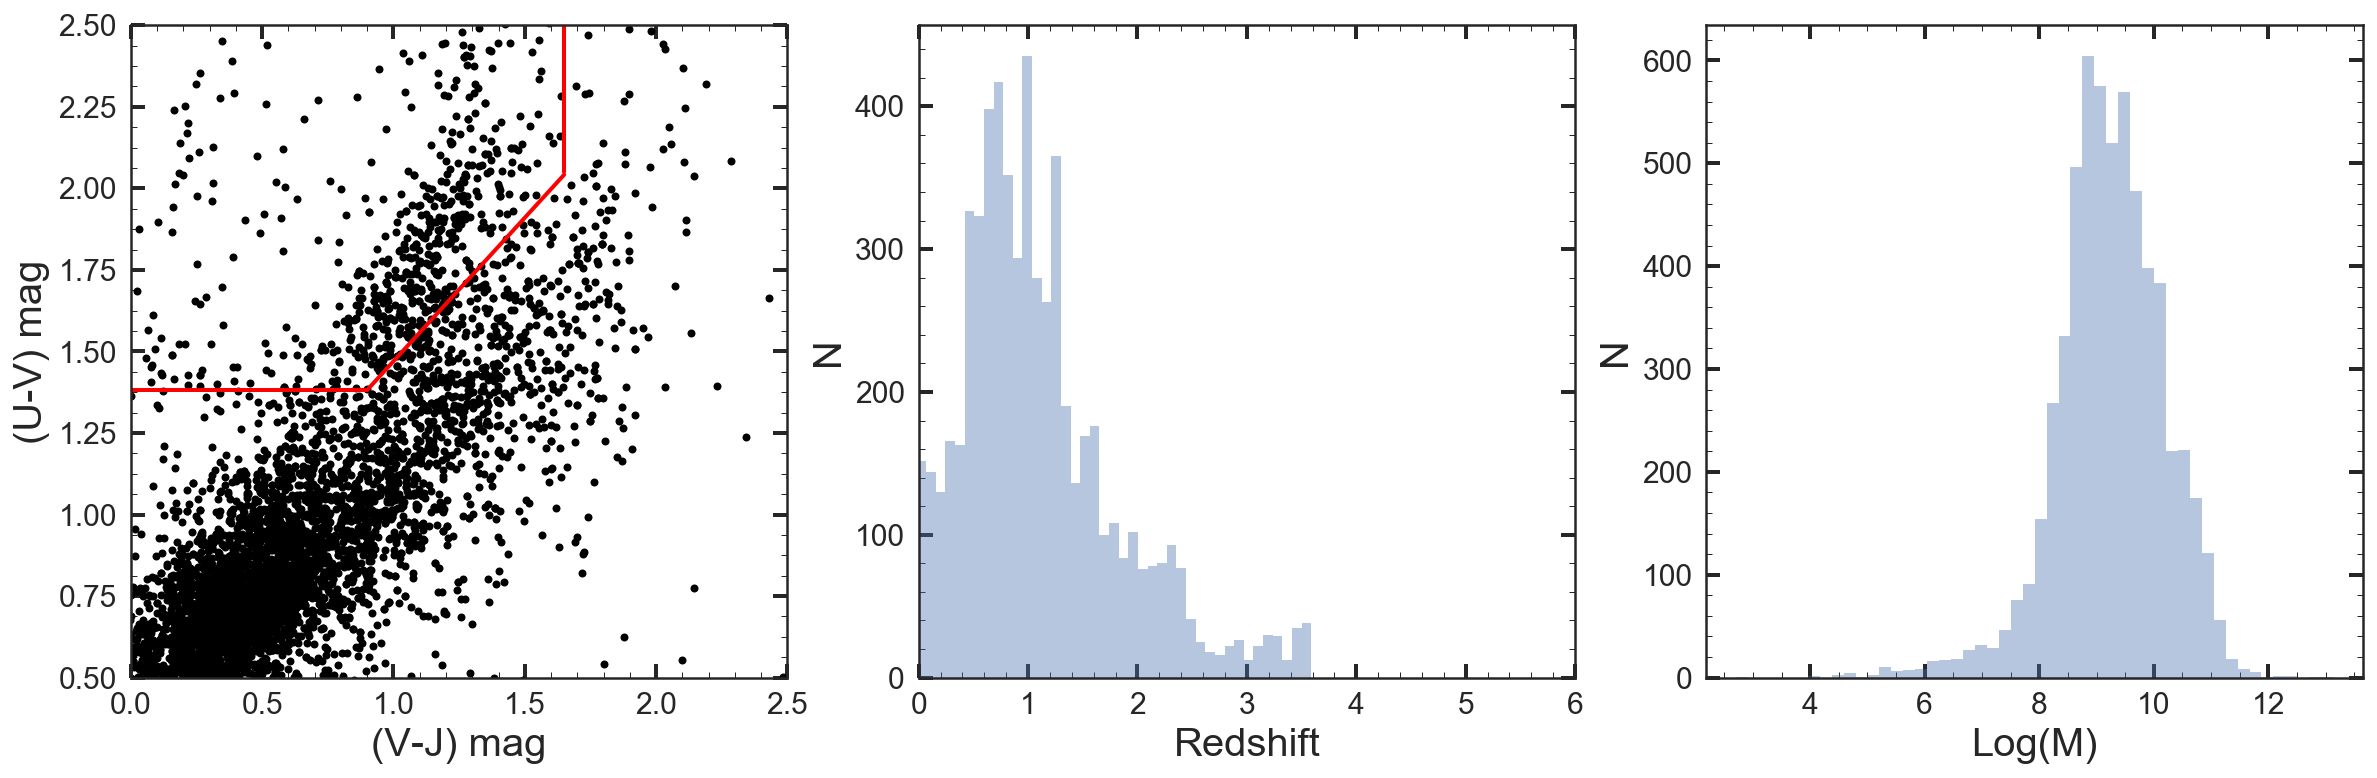

In [78]:
gs = gridspec.GridSpec(1,3)

plt.figure(figsize=[20,6])
plt.subplot(gs[0])
plt.plot(S_VJ_v4, S_UV_v4,'ko',ms=4)
plt.plot(N_VJ_v4, N_UV_v4,'ko',ms=4)

plt.plot([0,.9],[1.382,1.382],'r',lw=2)
plt.plot([1.65,1.65],[2.05,2.5],'r',lw=2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'r',lw=2)
plt.axis([0,2.5,.5,2.5])
plt.xlabel('(V-J) mag',fontsize=20)
plt.ylabel('(U-V) mag',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15,length = 7, width=2)

plt.subplot(gs[1])
sea.distplot(np.append(N_v4.z,S_v4.z),kde = False)
plt.xlabel('Redshift',fontsize=20)
plt.ylabel('N',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15,length = 7, width=2)
plt.xlim(0,6)

plt.subplot(gs[2])
sea.distplot(np.append(N_v4.query('lmass > 0').lmass, S_v4.query('lmass > 0').lmass),kde = False)
plt.xlabel('Log(M)',fontsize=20)
plt.ylabel('N',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15,length = 7, width=2)

########################################

plt.figure(figsize=[20,6])
plt.subplot(gs[0])
plt.plot(S_VJ_zg, S_UV_zg,'ko',ms=4)
plt.plot(N_VJ_zg, N_UV_zg,'ko',ms=4)

plt.plot([0,.9],[1.382,1.382],'r',lw=2)
plt.plot([1.65,1.65],[2.05,2.5],'r',lw=2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'r',lw=2)
plt.axis([0,2.5,.5,2.5])
plt.xlabel('(V-J) mag',fontsize=20)
plt.ylabel('(U-V) mag',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15,length = 7, width=2)

plt.subplot(gs[1])
sea.distplot(np.append(N_zg.z50,S_zg.z50),kde = False)
plt.xlabel('Redshift',fontsize=20)
plt.ylabel('N',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15,length = 7, width=2)
plt.xlim(0,6)

plt.subplot(gs[2])
sea.distplot(np.append(N_zg.query('lmass > 0').lmass, S_zg.query('lmass > 0').lmass),kde = False)
plt.xlabel('Log(M)',fontsize=20)
plt.ylabel('N',fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15,length = 7, width=2)

In [79]:
N_UV_v4 = Color(N_v4.query('z > 0.7 and lmass > 8.5').U,N_v4.query('z > 0.7 and lmass > 8.5').V)
N_VJ_v4 = Color(N_v4.query('z > 0.7 and lmass > 8.5').V,N_v4.query('z > 0.7 and lmass > 8.5').J)

S_UV_v4 = Color(S_v4.query('z > 0.7 and lmass > 8.5').U,S_v4.query('z > 0.7 and lmass > 8.5').V)
S_VJ_v4 = Color(S_v4.query('z > 0.7 and lmass > 8.5').V,S_v4.query('z > 0.7 and lmass > 8.5').J)

SQ_v4=[]

NQ_v4=[]

for i in N_UV_v4.index:
    if N_UV_v4[i]>=0.88*N_VJ_v4[i]+0.59 and N_UV_v4[i]>1.382 and N_VJ_v4[i]<1.65:
        NQ_v4.append(i)
        
for i in S_UV_v4.index:
    if S_UV_v4[i]>=0.88*S_VJ_v4[i]+0.59 and S_UV_v4[i]>1.382 and S_VJ_v4[i]<1.65:
        SQ_v4.append(i)
        

N_UV_zg = Color(N_zg.query('z50 > 0.7 and lmass > 8.5').U,N_zg.query('z50 > 0.7 and lmass > 8.5').V)
N_VJ_zg = Color(N_zg.query('z50 > 0.7 and lmass > 8.5').V,N_zg.query('z50 > 0.7 and lmass > 8.5').J)

S_UV_zg = Color(S_zg.query('z50 > 0.7 and lmass > 8.5').U,S_zg.query('z50 > 0.7 and lmass > 8.5').V)
S_VJ_zg = Color(S_zg.query('z50 > 0.7 and lmass > 8.5').V,S_zg.query('z50 > 0.7 and lmass > 8.5').J)

SQ_zg=[]

NQ_zg=[]

for i in N_UV_zg.index:
    if N_UV_zg[i]>=0.88*N_VJ_zg[i]+0.59 and N_UV_zg[i]>1.382 and N_VJ_zg[i]<1.65:
        NQ_zg.append(i)
        
for i in S_UV_zg.index:
    if S_UV_zg[i]>=0.88*S_VJ_zg[i]+0.59 and S_UV_zg[i]>1.382 and S_VJ_zg[i]<1.65:
        SQ_zg.append(i)

[0, 2.5, 0.5, 2.5]

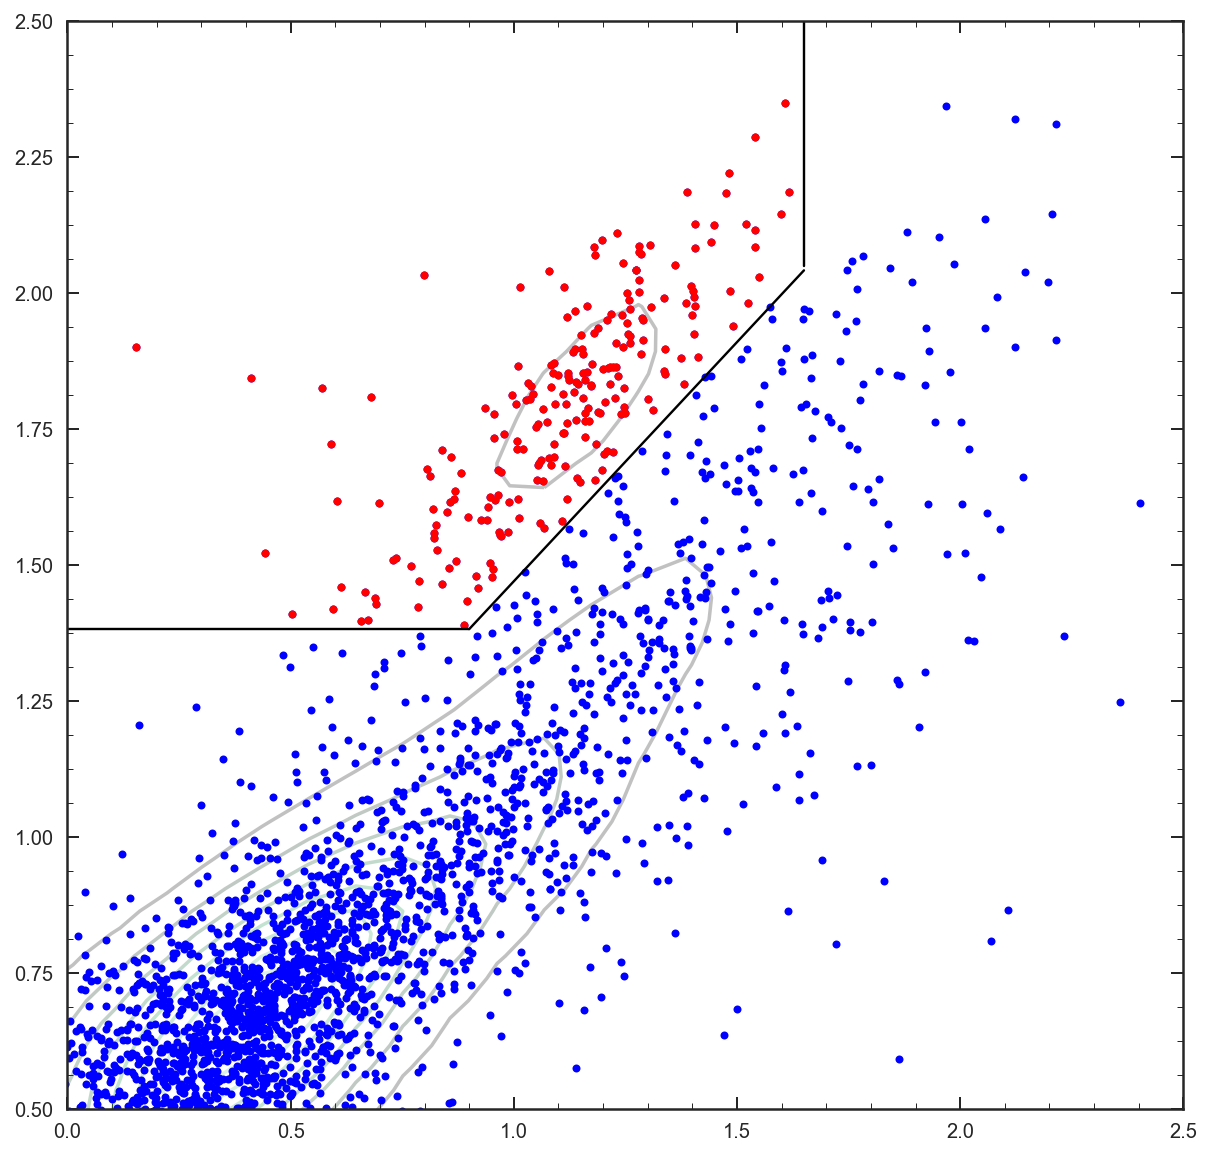

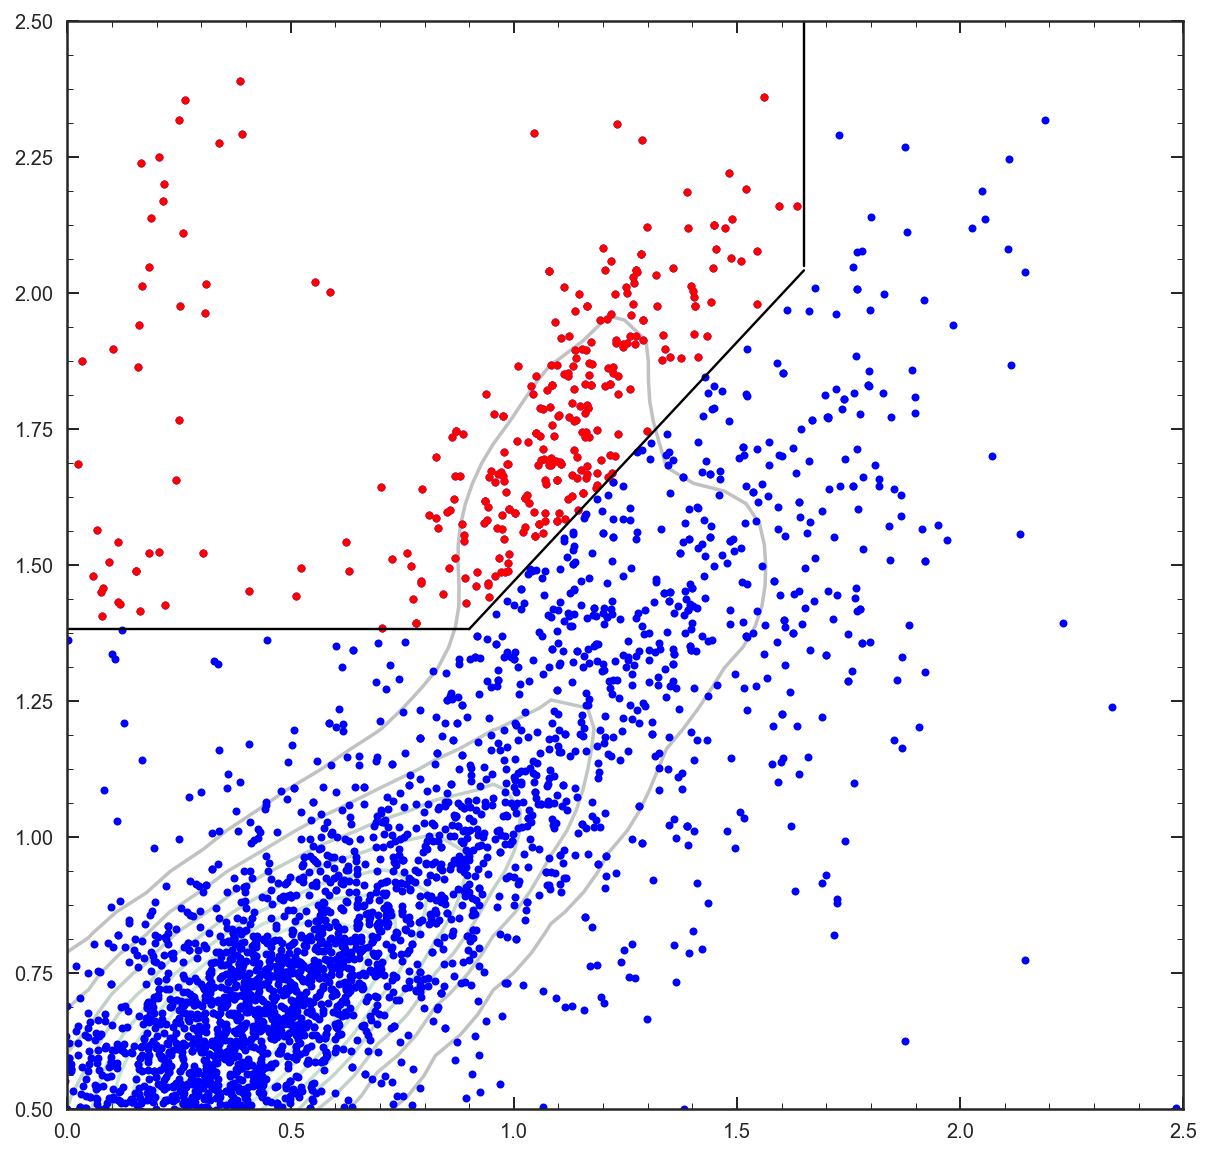

In [80]:
plt.figure(figsize=[10,10])
sea.kdeplot(np.append(S_VJ_v4,N_VJ_v4),np.append(S_UV_v4,N_UV_v4),alpha=0.3)

plt.plot(S_VJ_v4, S_UV_v4,'bo',ms=4)
plt.plot(N_VJ_v4, N_UV_v4,'bo',ms=4)

plt.plot(S_VJ_v4[SQ_v4], S_UV_v4[SQ_v4],'ro',ms=4)
plt.plot(N_VJ_v4[NQ_v4], N_UV_v4[NQ_v4],'ro',ms=4)

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

#######################

plt.figure(figsize=[10,10])
sea.kdeplot(np.append(S_VJ_zg,N_VJ_zg),np.append(S_UV_zg,N_UV_zg),alpha=0.3)

plt.plot(S_VJ_zg, S_UV_zg,'bo',ms=4)
plt.plot(N_VJ_zg, N_UV_zg,'bo',ms=4)

plt.plot(S_VJ_zg[SQ_zg], S_UV_zg[SQ_zg],'ro',ms=4)
plt.plot(N_VJ_zg[NQ_zg], N_UV_zg[NQ_zg],'ro',ms=4)

plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
plt.axis([0,2.5,.5,2.5])

In [81]:
Sid_v4 = S_v4.id[S_VJ_v4[SQ_v4].index].values
Nid_v4 = N_v4.id[N_VJ_v4[NQ_v4].index].values

Sid_zg = S_zg.id[S_VJ_zg[SQ_zg].index].values
Nid_zg = N_zg.id[N_VJ_zg[NQ_zg].index].values

In [82]:
len(Sid_v4), len(set(Sid_zg))

(84, 86)

In [83]:
len(Nid_v4), len(set(Nid_zg))

(150, 184)

In [84]:
Sid_zgs = list(set(Sid_zg))
Nid_zgs = list(set(Nid_zg))

In [85]:
Sid_all = np.array(list(set(np.append(Sid_v4, Sid_zg))))

In [86]:
Nid_all = np.array(list(set(np.append(Nid_v4, Nid_zg))))

In [87]:
specsglob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*S*/*/Prep/*41520.1D.fits')

NameError: name 'specsglob' is not defined

In [90]:
S_SNR = []
for i in Sid_all:
    S_SNR.append(Extract_spec('S',i))

N_SNR = []
for i in Nid_all:
    sn = Extract_spec('N',i)
    if sn == None:
        N_SNR.append(0)
    else:
        N_SNR.append(sn)

/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:41: RuntimeWarning: divide by zero encountered in power
  weigrid = errgrid ** (-2)
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:48: RuntimeWarning: invalid value encountered in double_scalars
  stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:49: RuntimeWarning: invalid value encountered in double_scalars
  stack_flat[i] = np.sum(fltgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:50: RuntimeWarning: invalid value encountered in double_scalars
  stack_line[i] = np.sum(linegrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_field/scripts/spec_extract.py:51: RuntimeWarning: invalid value encountered in double_scalars
  stack_cont[i] = np.sum(contgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/vestrada/Github/Cluster_and_fiel

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


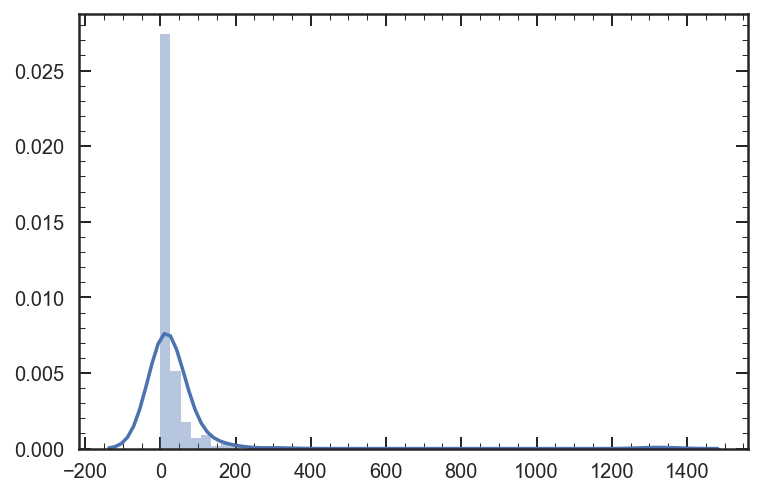

In [91]:
sea.distplot(N_SNR)

In [94]:
len(np.array(Sid_all)[np.array(S_SNR) > 10])

58

In [93]:
len(np.array(Nid_all)[np.array(N_SNR) > 10])

117

In [95]:
S_sndb = pd.DataFrame({'id' : np.array(Sid_all)[np.array(S_SNR) > 10], 'snr' : np.array(S_SNR)[np.array(S_SNR) > 10]})
N_sndb = pd.DataFrame({'id' : np.array(Nid_all)[np.array(N_SNR) > 10], 'snr' : np.array(N_SNR)[np.array(N_SNR) > 10]})

In [97]:
S_sndb.to_pickle('../dataframes/GS_snr.pkl')
N_sndb.to_pickle('../dataframes/GN_snr.pkl')

In [89]:
def Sig_int(er):
    sig = np.zeros(len(er)-1)
    
    for i in range(len(er)-1):
        sig[i] = np.sqrt(er[i]**2 + er[i+1]**2 )
    
    return np.sum((1/2)*sig)

def SN(w, f, e, wmin, wmax):
    
    IDx = [U for U in range(len(w)) if wmin < w[U] < wmax]
    
    return np.trapz(f[IDx])/ Sig_int(e[IDx])

def SN_full(Bw, Bf, Be, Rw, Rf, Re, Bmin, Bmax, Rmin, Rmax):
    
    IDb = [U for U in range(len(Bw)) if Bmin < Bw[U] < Bmax]
    IDr = [U for U in range(len(Rw)) if Rmin < Rw[U] < Rmax]
    
    return np.trapz(np.append(Bf[IDb],Rf[IDr]))/ Sig_int(np.append(Be[IDb],Re[IDr]))

def Extract_spec(Field, galaxy_id ):
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.0.0/*{0}*/*/Prep/*{1}*1D.fits'.format(Field, galaxy_id))

    Bwv, Bfl, Ber, Bft, Bln, Bct = [[],[],[],[],[],[]]

    Rwv, Rfl, Rer, Rft, Rln, Rct = [[],[],[],[],[],[]]

    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])

        try:
            Bwv.append(np.array(dat['G102'].data['wave']).T)
            Bfl.append(np.array(dat['G102'].data['flux']).T)
            Ber.append(np.array(dat['G102'].data['err']).T)
            Bft.append(np.array(dat['G102'].data['flat']).T)
            Bln.append(np.array(dat['G102'].data['line']).T)
            Bct.append(np.array(dat['G102'].data['cont']).T)

        except:
            u='dummy'
            
        try:
            Rwv.append(np.array(dat['G141'].data['wave']).T)
            Rfl.append(np.array(dat['G141'].data['flux']).T)
            Rer.append(np.array(dat['G141'].data['err']).T)
            Rft.append(np.array(dat['G141'].data['flat']).T)
            Rln.append(np.array(dat['G141'].data['line']).T)
            Rct.append(np.array(dat['G141'].data['cont']).T)

        except:
            u='dummy'
            
    if len(Bwv) > 0:                
        SBW, SBF, SBE, SBT, SBL, SBC = Stack(Bwv, Bfl, Ber, Bft, Bln, Bct)
    
        SBW = SBW[SBF**2 > 0]
        SBE = SBE[SBF**2 > 0]
        SBF = SBF[SBF**2 > 0]
        SNB = SN(SBW, SBF, SBE, min(SBW), max(SBW))
    else:
        SNB = 0
    
    if len(Rwv) > 0:     
        SRW, SRF, SRE, SRT, SRL, SRC = Stack(Rwv, Rfl, Rer, Rft, Rln, Rct)

        SRW = SRW[SRF**2 > 0]
        SRE = SRE[SRF**2 > 0]
        SRF = SRF[SRF**2 > 0]
        SNR = SN(SRW, SRF, SRE, min(SRW), max(SRW))
    else:
        SNR = 0
    
    if SNR == 0:
        return SNB
    if SNB == 0:
        return SNR
    if SNB > 0 and SNR > 0:
        return (SNB + SNR) / 2
    if SNR == 0 and SNB == 0:
        return 0


In [37]:
print(112.94867664265428/169)
print(88.16813947574848/144)

# 94.3847517320734

0.6683353647494336
0.6122787463593644


In [103]:
for i in S_sndb.id.values:
    if i not in N_sndb.id.values:
        print(i)

37897
44042
40476
43548
47140
39976
39981
41520
34363
47691
43615
38513
47223
42113
41108
40597
46231
35993
43674
36001
40611
49836
40623
41148
46275
44228
42185
45775
49362
45789
35046
49402
46846
36095
39681
38671
44824
47386
38191
47421
45915
42347
39804
39805
38785
43401
44946
45972
47002
42409
39850
46001
35774
37828
37362
36854
42487
43005


# check 4.4 outputs

In [148]:
ezin = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'), 
                  format = 'fits').to_pandas()
eztest = Table.read('/Users/Vince.ec/eazy-photoz/GN/products/goodsn_3dhst.v4.4.zout',format = 'ascii').to_pandas()

In [151]:
eztest = eztest.query('id < 50000')

[0, 7, 0, 7]

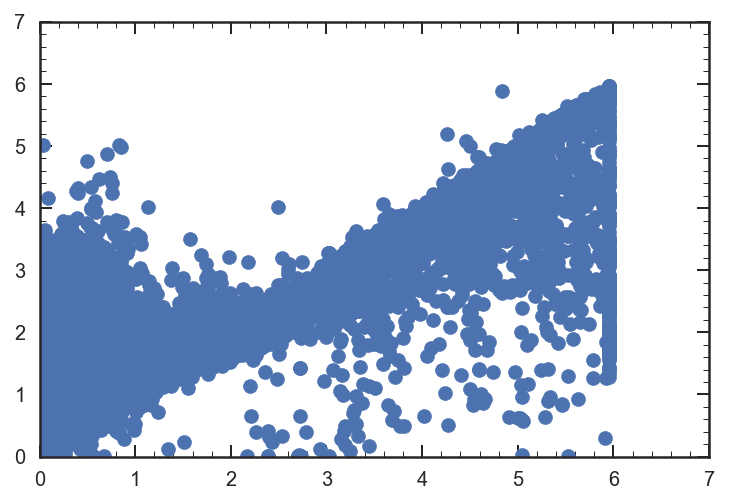

In [157]:
plt.scatter( ezin.z_chi2_noprior, eztest.z_m2 )
plt.axis([0,7,0,7])

In [2]:
v1N = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/RF_colors/goodsn_3dhst.v4.1.master.RF', 
                 format='ascii').to_pandas()
v1S = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/RF_colors/goodss_3dhst.v4.1.master.RF', 
                 format='ascii').to_pandas()

v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

In [3]:
v1Ncat = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Catalog/goodsn_3dhst.v4.1.cat', 
                 format='ascii').to_pandas()
v1Scat = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Catalog/goodss_3dhst.v4.1.cat', 
                 format='ascii').to_pandas()

v4Ncat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                 format='ascii').to_pandas()
v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

In [4]:
v1Nfast = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout', 
                 format='ascii').to_pandas()
v1Sfast = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout', 
                 format='ascii').to_pandas()


In [14]:
UN1 = [] ; UN1z = [] 
UN4 = [] ; UN4z = []
VN1 = [] ; VN1z = []
VN4 = [] ; VN4z = []
JN1 = [] ; JN1z = []
JN4 = [] ; JN4z = []
for i in v1N.index:
    if v1N.L153[i] > 0 and v4N.restU[i] > 0 and v1Ncat.use_phot[i] == 1 and v4Ncat.use_phot[i] == 1: 
        UN1.append(v1N.L153[i])
        UN4.append(v4N.restU[i])
        
        UN1z.append(v1N.z[i])
        UN4z.append(v4N.z_phot[i])
        
    if v1N.L155[i] > 0 and v4N.restV[i] > 0 and v1Ncat.use_phot[i] == 1 and v4Ncat.use_phot[i] == 1: 
        VN1.append(v1N.L155[i])
        VN4.append(v4N.restV[i])
                
        VN1z.append(v1N.z[i])
        VN4z.append(v4N.z_phot[i])
        
    if v1N.L161[i] > 0 and v4N.restJ[i] > 0 and v1Ncat.use_phot[i] == 1 and v4Ncat.use_phot[i] == 1: 
        JN1.append(v1N.L161[i])
        JN4.append(v4N.restJ[i])
                
        JN1z.append(v1N.z[i])
        JN4z.append(v4N.z_phot[i])
        
US1 = [] ; US1z = [] 
US4 = [] ; US4z = []
VS1 = [] ; VS1z = []
VS4 = [] ; VS4z = []
JS1 = [] ; JS1z = []
JS4 = [] ; JS4z = []
for i in v1S.index:
    if v1S.L153[i] > 0 and v4S.restU[i] > 0 and v1Scat.use_phot[i] == 1 and v4Scat.use_phot[i] == 1: 
        US1.append(v1S.L153[i])
        US4.append(v4S.restU[i])
        
        US1z.append(v1S.z[i])
        US4z.append(v4S.z_phot[i])
        
    if v1S.L155[i] > 0 and v4S.restV[i] > 0 and v1Scat.use_phot[i] == 1 and v4Scat.use_phot[i] == 1: 
        VS1.append(v1S.L155[i])
        VS4.append(v4S.restV[i])
                
        VS1z.append(v1S.z[i])
        VS4z.append(v4S.z_phot[i])
        
    if v1S.L161[i] > 0 and v4S.restJ[i] > 0 and v1Scat.use_phot[i] == 1 and v4Scat.use_phot[i] == 1: 
        JS1.append(v1S.L161[i])
        JS4.append(v4S.restJ[i])
                
        JS1z.append(v1S.z[i])
        JS4z.append(v4S.z_phot[i])

In [15]:
def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

def Mag(flux):
    return 25 - 2.5*np.log10(flux)

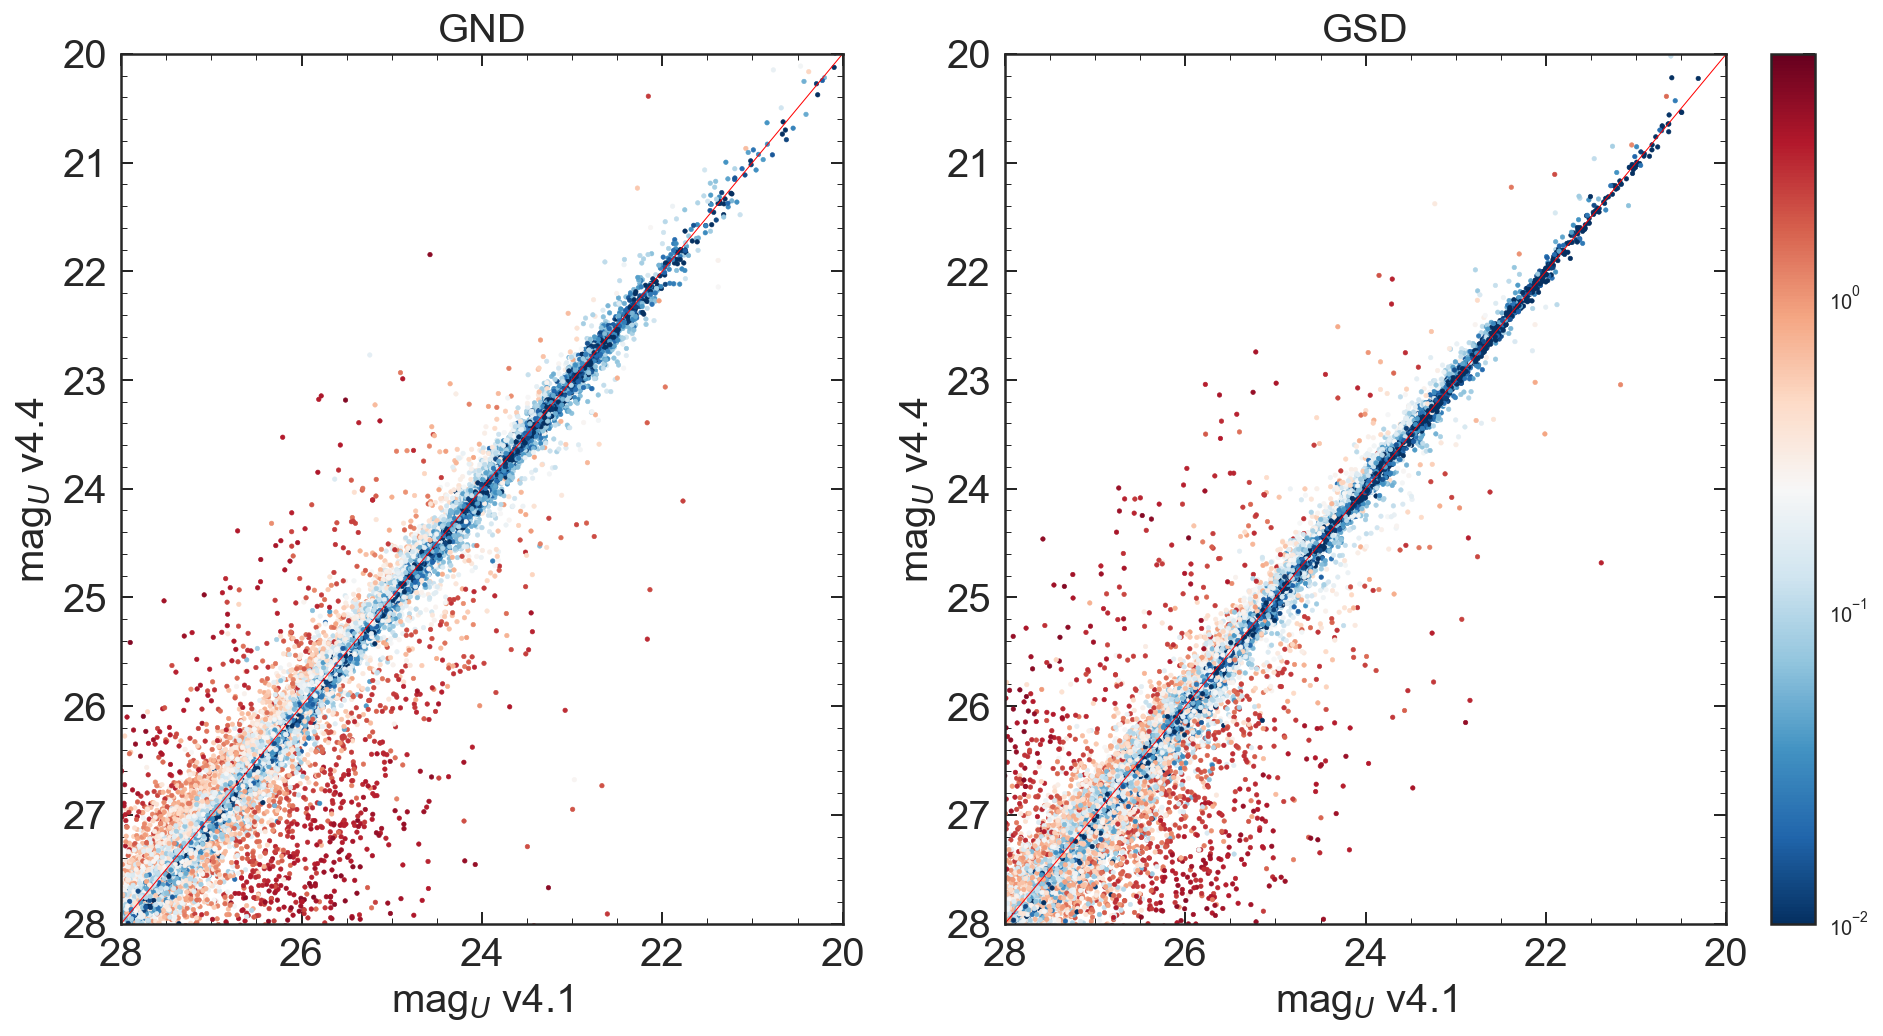

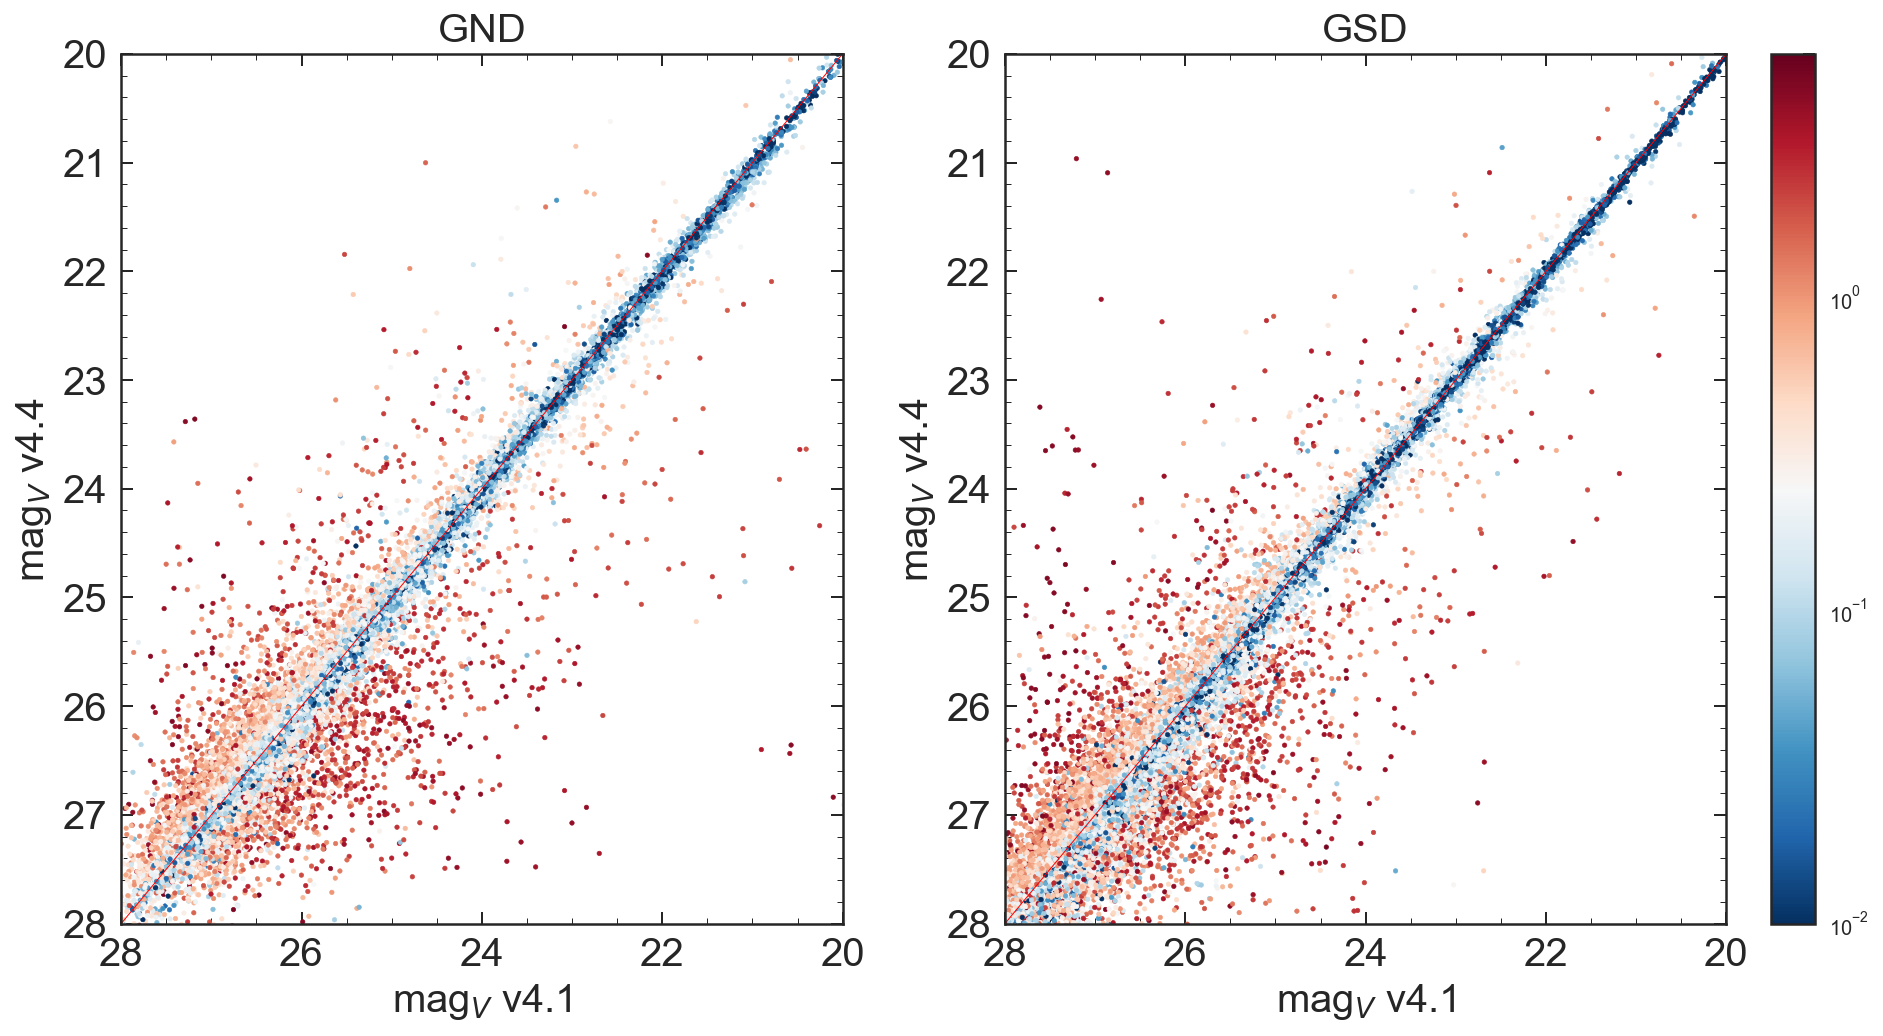

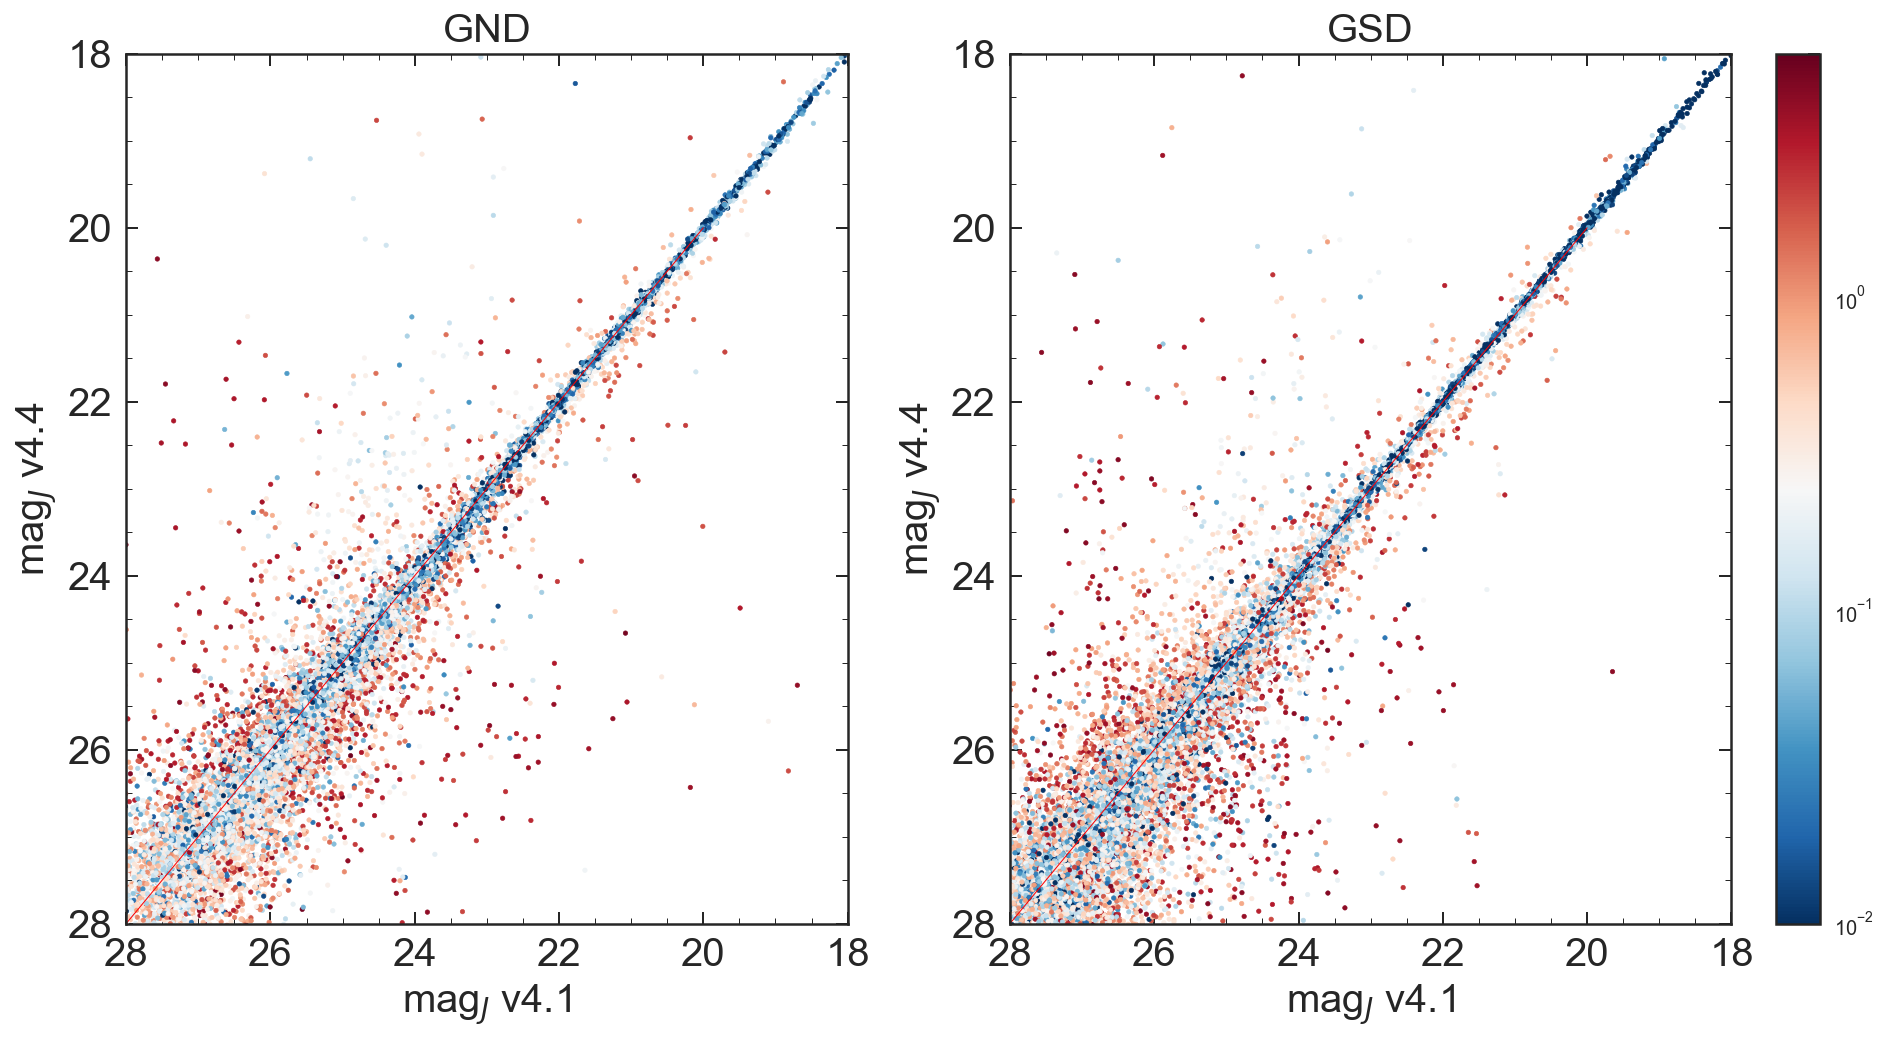

In [16]:
gs = gridspec.GridSpec(1,2, width_ratios=[8,10])

plt.figure(figsize=[16,8])
plt.subplot(gs[0])
plt.scatter(Mag(UN1),Mag(UN4),s=5,
            c=np.abs(np.array(UN1z) - np.array(UN4z)), norm=colors.LogNorm(vmin=0.01, vmax=6), cmap='RdBu_r')
plt.plot([20,30],[20,30],'r',linewidth = 0.5)
plt.xlabel('mag$_U$ v4.1', fontsize=20)
plt.ylabel('mag$_U$ v4.4', fontsize=20)
plt.title('GND', fontsize=20)
plt.ylim(28,20)
plt.xlim(28,20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(gs[1])
plt.scatter(Mag(US1),Mag(US4),s=5,
            c=np.abs(np.array(US1z) - np.array(US4z)), norm=colors.LogNorm(vmin=0.01, vmax=6), cmap='RdBu_r')

plt.plot([20,30],[20,30],'r',linewidth = 0.5)
plt.xlabel('mag$_U$ v4.1', fontsize=20)
plt.ylabel('mag$_U$ v4.4', fontsize=20)
plt.title('GSD', fontsize=20)
plt.ylim(28,20)
plt.xlim(28,20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar()
plt.savefig('../plots/UVJ_comp/U_1-v.png' ,bbox_inches = 'tight')
##########

plt.figure(figsize=[16,8])
plt.subplot(gs[0])
plt.scatter(Mag(VN1),Mag(VN4),s=5,
            c=np.abs(np.array(VN1z) - np.array(VN4z)), norm=colors.LogNorm(vmin=0.01, vmax=6), cmap='RdBu_r')

plt.plot([20,30],[20,30],'r',linewidth = 0.5)
plt.xlabel('mag$_V$ v4.1', fontsize=20)
plt.ylabel('mag$_V$ v4.4', fontsize=20)
plt.title('GND', fontsize=20)
plt.ylim(28,20)
plt.xlim(28,20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(gs[1])
plt.scatter(Mag(VS1),Mag(VS4),s=5,
            c=np.abs(np.array(VS1z) - np.array(VS4z)), norm=colors.LogNorm(vmin=0.01, vmax=6), cmap='RdBu_r')

plt.plot([20,30],[20,30],'r',linewidth = 0.5)
plt.xlabel('mag$_V$ v4.1', fontsize=20)
plt.ylabel('mag$_V$ v4.4', fontsize=20)
plt.title('GSD', fontsize=20)
plt.ylim(28,20)
plt.xlim(28,20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar()

plt.savefig('../plots/UVJ_comp/V_1-v.png' ,bbox_inches = 'tight')

##########

plt.figure(figsize=[16,8])
plt.subplot(gs[0])
plt.scatter(Mag(JN1),Mag(JN4),s=5,
            c=np.abs(np.array(JN1z) - np.array(JN4z)), norm=colors.LogNorm(vmin=0.01, vmax=6), cmap='RdBu_r')

plt.plot([20,30],[20,30],'r',linewidth = 0.5)
plt.xlabel('mag$_J$ v4.1', fontsize=20)
plt.ylabel('mag$_J$ v4.4', fontsize=20)
plt.title('GND', fontsize=20)
plt.ylim(28,18)
plt.xlim(28,18)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(gs[1])
plt.scatter(Mag(JS1),Mag(JS4),s=5,
            c=np.abs(np.array(JS1z) - np.array(JS4z)), norm=colors.LogNorm(vmin=0.01, vmax=6), cmap='RdBu_r')

plt.plot([20,30],[20,30],'r',linewidth = 0.5)
plt.xlabel('mag$_J$ v4.1', fontsize=20)
plt.ylabel('mag$_J$ v4.4', fontsize=20)
plt.title('GSD', fontsize=20)
plt.ylim(28,18)
plt.xlim(28,18)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar()

plt.savefig('../plots/UVJ_comp/J_1-v.png' ,bbox_inches = 'tight')


In [20]:
uvjcatN4 = v4N
uvjcatS4 = v4S
uvjcatN1 = v1N
uvjcatS1 = v1S

In [21]:
uvjcatN4['use'] = v4Ncat['use_phot']
uvjcatS4['use'] = v4Scat['use_phot']

uvjcatN1['use'] = v1Ncat['use_phot']
uvjcatS1['use'] = v1Scat['use_phot']

uvjcatN4['star'] = v4Ncat['class_star']
uvjcatS4['star'] = v4Scat['class_star']

uvjcatN1['star'] = v1Ncat['class_star']
uvjcatS1['star'] = v1Scat['class_star']

uvjcatN1['lmass'] = v1Nfast['lmass']
uvjcatS1['lmass'] = v1Sfast['lmass']

In [54]:
uvjcatN1['Av'] = v1Nfast['Av']
uvjcatS1['Av'] = v1Sfast['Av']

In [35]:
UVN1 = Color(uvjcatN1.query('use == 1 and lmass > 9.5').L153, uvjcatN1.query('use == 1 and lmass > 9.5').L155)
VJN1 = Color(uvjcatN1.query('use == 1 and lmass > 9.5').L155, uvjcatN1.query('use == 1 and lmass > 9.5').L161)
UVS1 = Color(uvjcatS1.query('use == 1 and lmass > 9.5').L153, uvjcatS1.query('use == 1 and lmass > 9.5').L155)
VJS1 = Color(uvjcatS1.query('use == 1 and lmass > 9.5').L155, uvjcatS1.query('use == 1 and lmass > 9.5').L161)

UVN4 = Color(uvjcatN4.query('use == 1 and mass > 10**9.5').restU, uvjcatN4.query('use == 1 and mass > 10**9.5').restV)
VJN4 = Color(uvjcatN4.query('use == 1 and mass > 10**9.5').restV, uvjcatN4.query('use == 1 and mass > 10**9.5').restJ)
UVS4 = Color(uvjcatS4.query('use == 1 and mass > 10**9.5').restU, uvjcatS4.query('use == 1 and mass > 10**9.5').restV)
VJS4 = Color(uvjcatS4.query('use == 1 and mass > 10**9.5').restV, uvjcatS4.query('use == 1 and mass > 10**9.5').restJ)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
UVN1 = [] ; UVN1M = [] 
UVN4 = [] ; UVN4M = []
VJN1 = [] ; VJN1M = []
VJN4 = [] ; VJN4M = []

for i in v1N.index:
    if v1Ncat.use_phot[i] == 1 and v4Ncat.use_phot[i] == 1: 
        UVN1.append(Color(v1N.L153[i],v1N.L155[i] ))
        UVN4.append(Color(v4N.restU[i],v4N.restV[i] ))
        
        UVN1M.append(v1Nfast.lmass[i])
        UVN4M.append(v4N.mass[i])
        
        VJN1.append(Color(v1N.L155[i],v1N.L161[i]))
        VJN4.append(Color(v4N.restV[i],v4N.restJ[i]))
                
        VJN1M.append(v1Nfast.lmass[i])
        VJN4M.append(v4N.mass[i])
        
UVS1 = [] ; UVS1M = [] 
UVS4 = [] ; UVS4M = []
VJS1 = [] ; VJS1M = []
VJS4 = [] ; VJS4M = []

for i in v1S.index:
    if v1Scat.use_phot[i] == 1 and v4Scat.use_phot[i] == 1: 
        UVS1.append(Color(v1S.L153[i],v1S.L155[i] ))
        UVS4.append(Color(v4S.restU[i],v4S.restV[i] ))
        
        UVS1M.append(v1Sfast.lmass[i])
        UVS4M.append(v4S.mass[i])
        
        VJS1.append(Color(v1S.L155[i],v1S.L161[i]))
        VJS4.append(Color(v4S.restV[i],v4S.restJ[i]))
                
        VJS1M.append(v1Sfast.lmass[i])
        VJS4M.append(v4S.mass[i])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


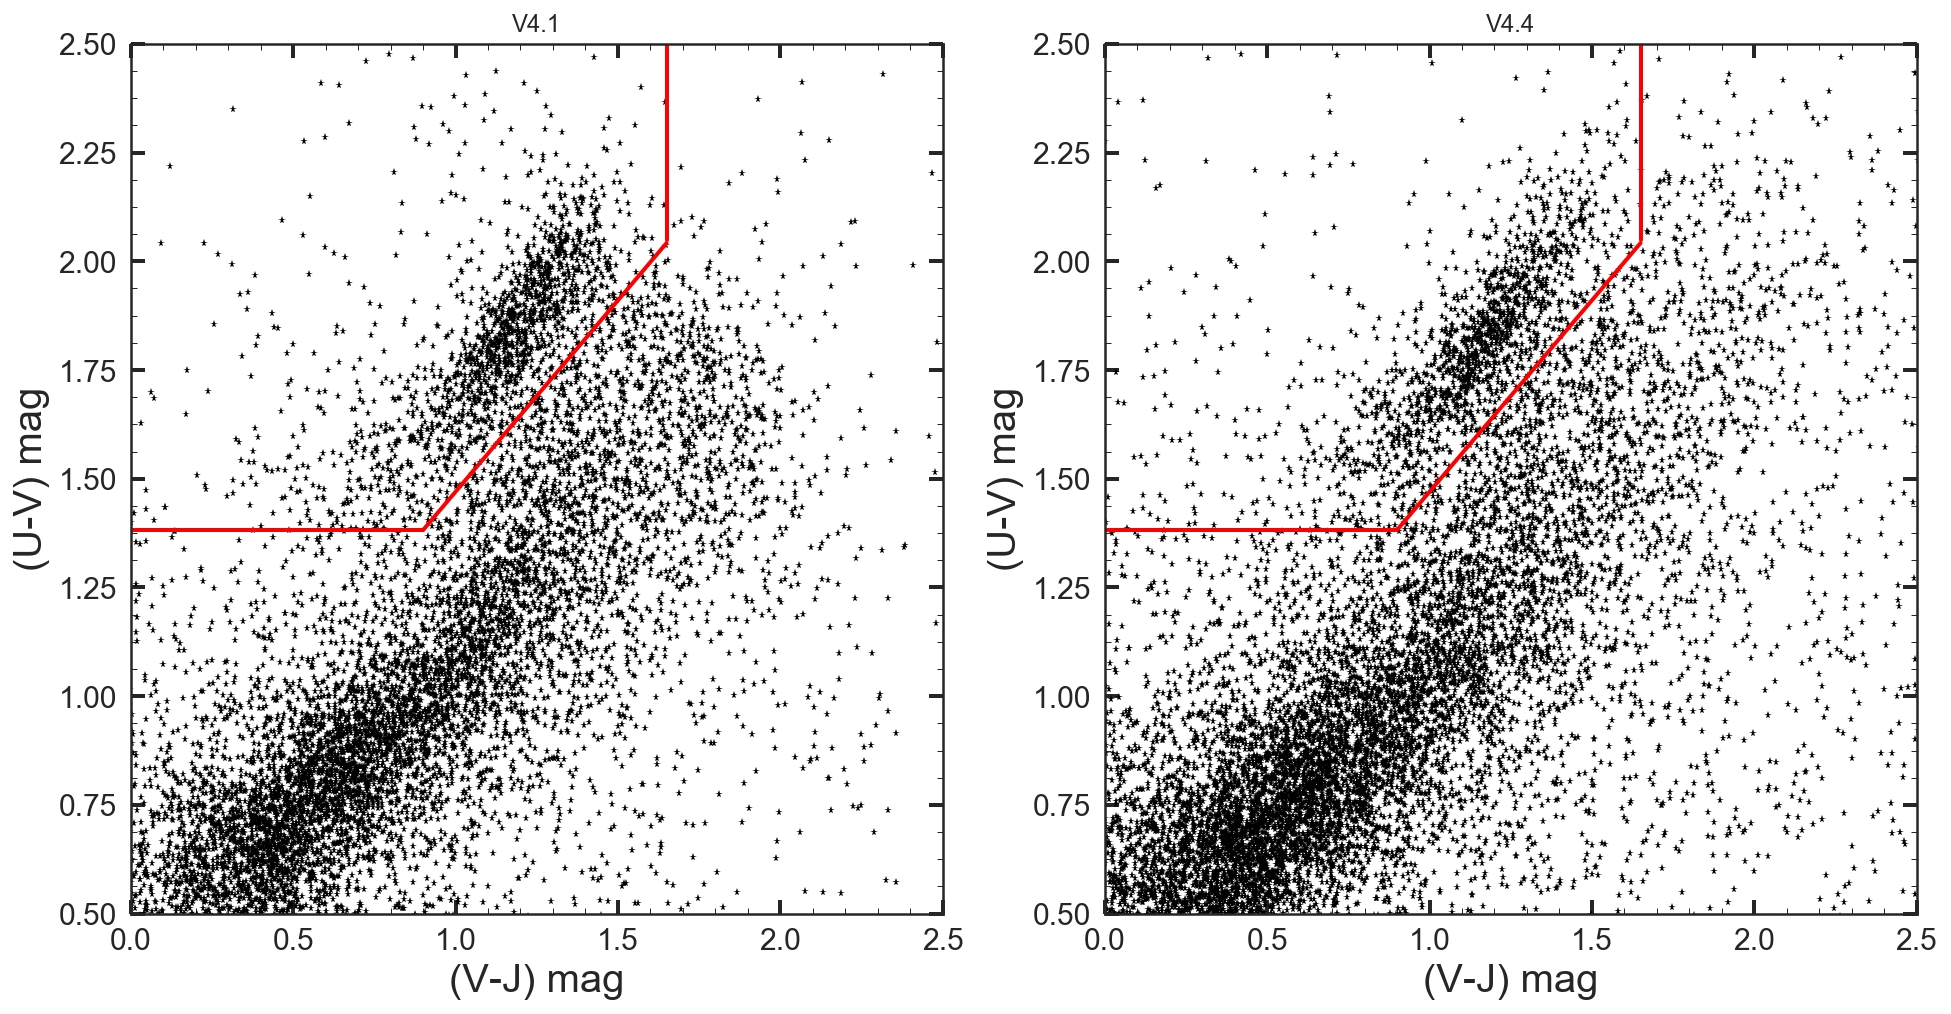

In [40]:
gs = gridspec.GridSpec(1,2)

plt.figure(figsize=[16,8])
plt.subplot(gs[0])

plt.plot(VJN1, UVN1,'k*',ms=4)
plt.plot(VJS1, UVS1,'k*',ms=4)

plt.plot([0,.9],[1.382,1.382],'r',lw=2)
plt.plot([1.65,1.65],[2.05,2.5],'r',lw=2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'r',lw=2)
plt.axis([0,2.5,.5,2.5])
plt.xlabel('(V-J) mag',fontsize=20)
plt.ylabel('(U-V) mag',fontsize=20)
plt.title('V4.1')
plt.tick_params(axis='both', which='major', labelsize=15,length = 7, width=2)

plt.subplot(gs[1])

plt.plot(VJN4, UVN4,'k*',ms=4)
plt.plot(VJS4, UVS4,'k*',ms=4)

plt.plot([0,.9],[1.382,1.382],'r',lw=2)
plt.plot([1.65,1.65],[2.05,2.5],'r',lw=2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'r',lw=2)
plt.axis([0,2.5,.5,2.5])
plt.xlabel('(V-J) mag',fontsize=20)
plt.ylabel('(U-V) mag',fontsize=20)
plt.title('V4.4')
plt.tick_params(axis='both', which='major', labelsize=15,length = 7, width=2)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log10


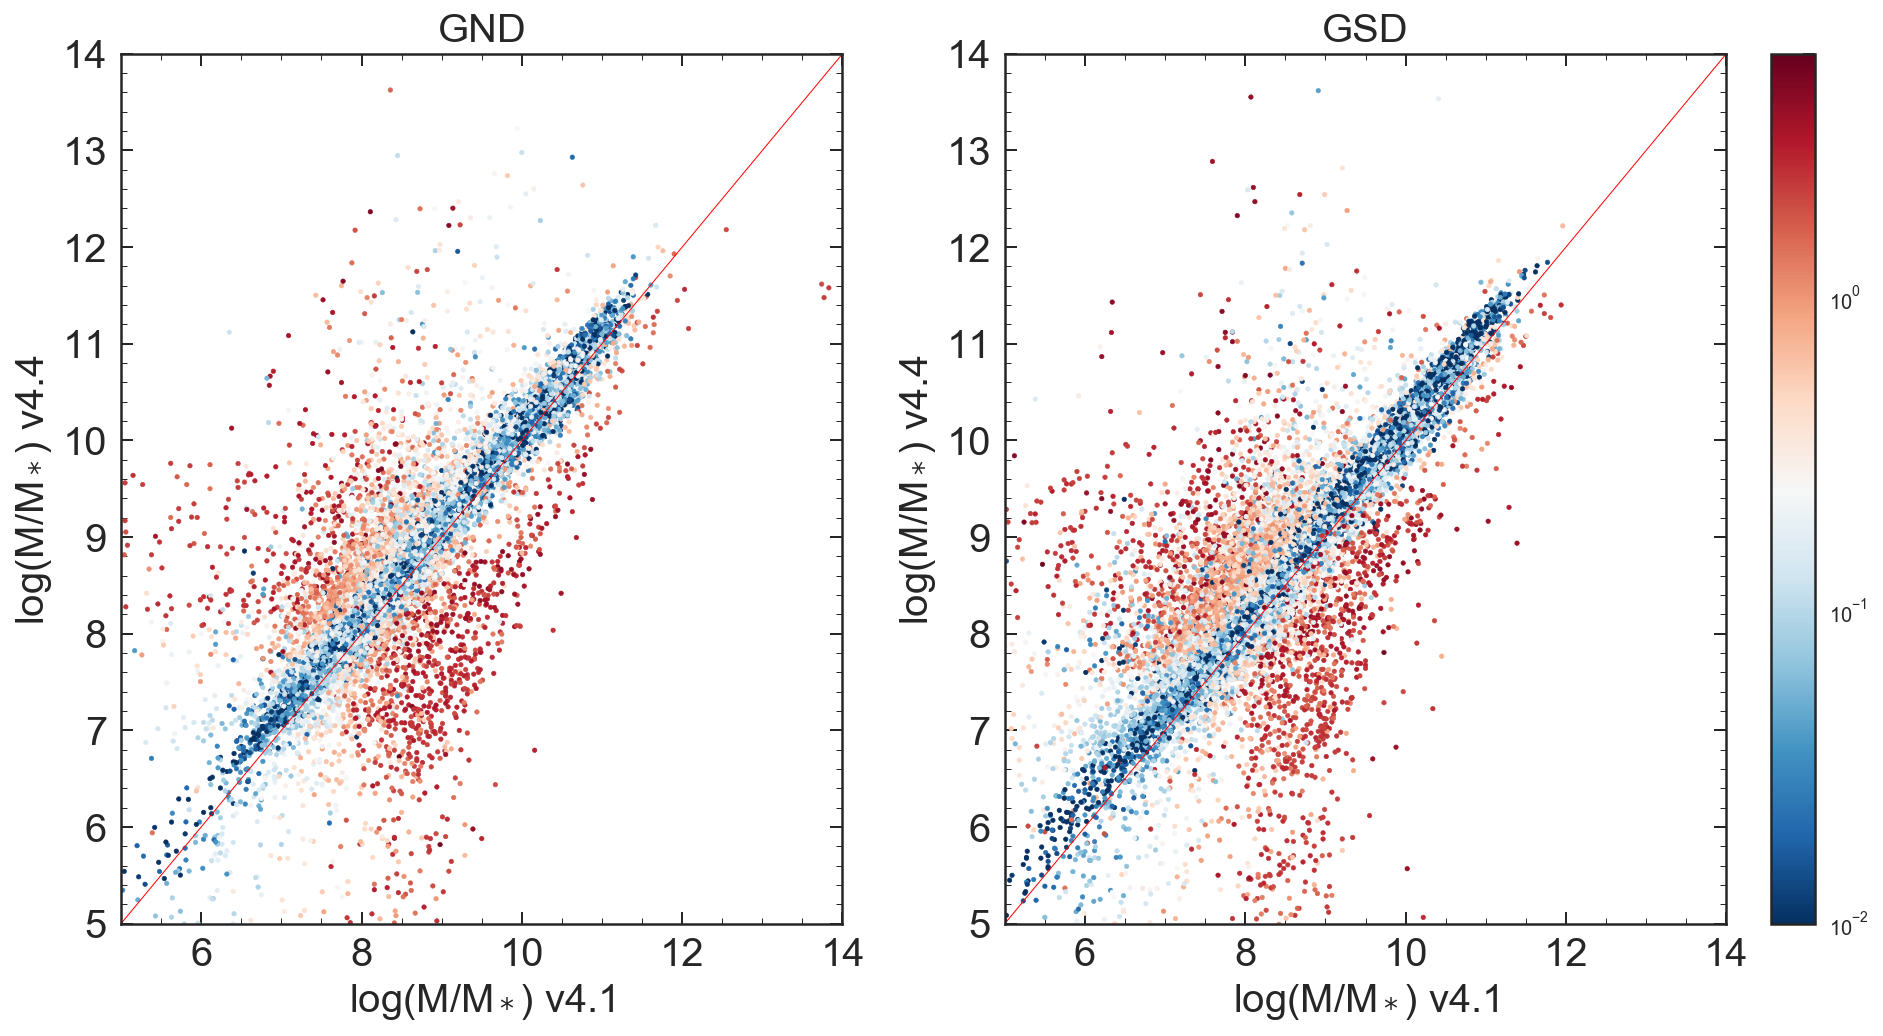

In [53]:
gs = gridspec.GridSpec(1,2, width_ratios=[8,10])

plt.figure(figsize=[16,8])
plt.subplot(gs[0])
plt.scatter(uvjcatN1.query('use == 1 and star < 0.8').lmass,np.log10(uvjcatN4.query('use == 1 and star < 0.8').mass),s=5,
            c=np.abs(np.array(uvjcatN1.query('use == 1 and star < 0.8').z) - np.array(uvjcatN4.query('use == 1 and star < 0.8').z_phot)), 
            norm=colors.LogNorm(vmin=0.01, vmax=6), cmap='RdBu_r')
plt.plot([5,14],[5,14],'r',linewidth = 0.5)
plt.xlabel('log(M/M$_*$) v4.1', fontsize=20)
plt.ylabel('log(M/M$_*$) v4.4', fontsize=20)
plt.title('GND', fontsize=20)
plt.ylim(5,14)
plt.xlim(5,14)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(gs[1])
plt.scatter(uvjcatS1.query('use == 1 and star < 0.8').lmass,np.log10(uvjcatS4.query('use == 1 and star < 0.8').mass),s=5,
            c=np.abs(np.array(uvjcatS1.query('use == 1 and star < 0.8').z) - np.array(uvjcatS4.query('use == 1 and star < 0.8').z_phot)), 
            norm=colors.LogNorm(vmin=0.01, vmax=6), cmap='RdBu_r')

plt.plot([5,14],[5,14],'r',linewidth = 0.5)
plt.xlabel('log(M/M$_*$) v4.1', fontsize=20)
plt.ylabel('log(M/M$_*$) v4.4', fontsize=20)
plt.title('GSD', fontsize=20)
plt.ylim(5,14)
plt.xlim(5,14)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar()

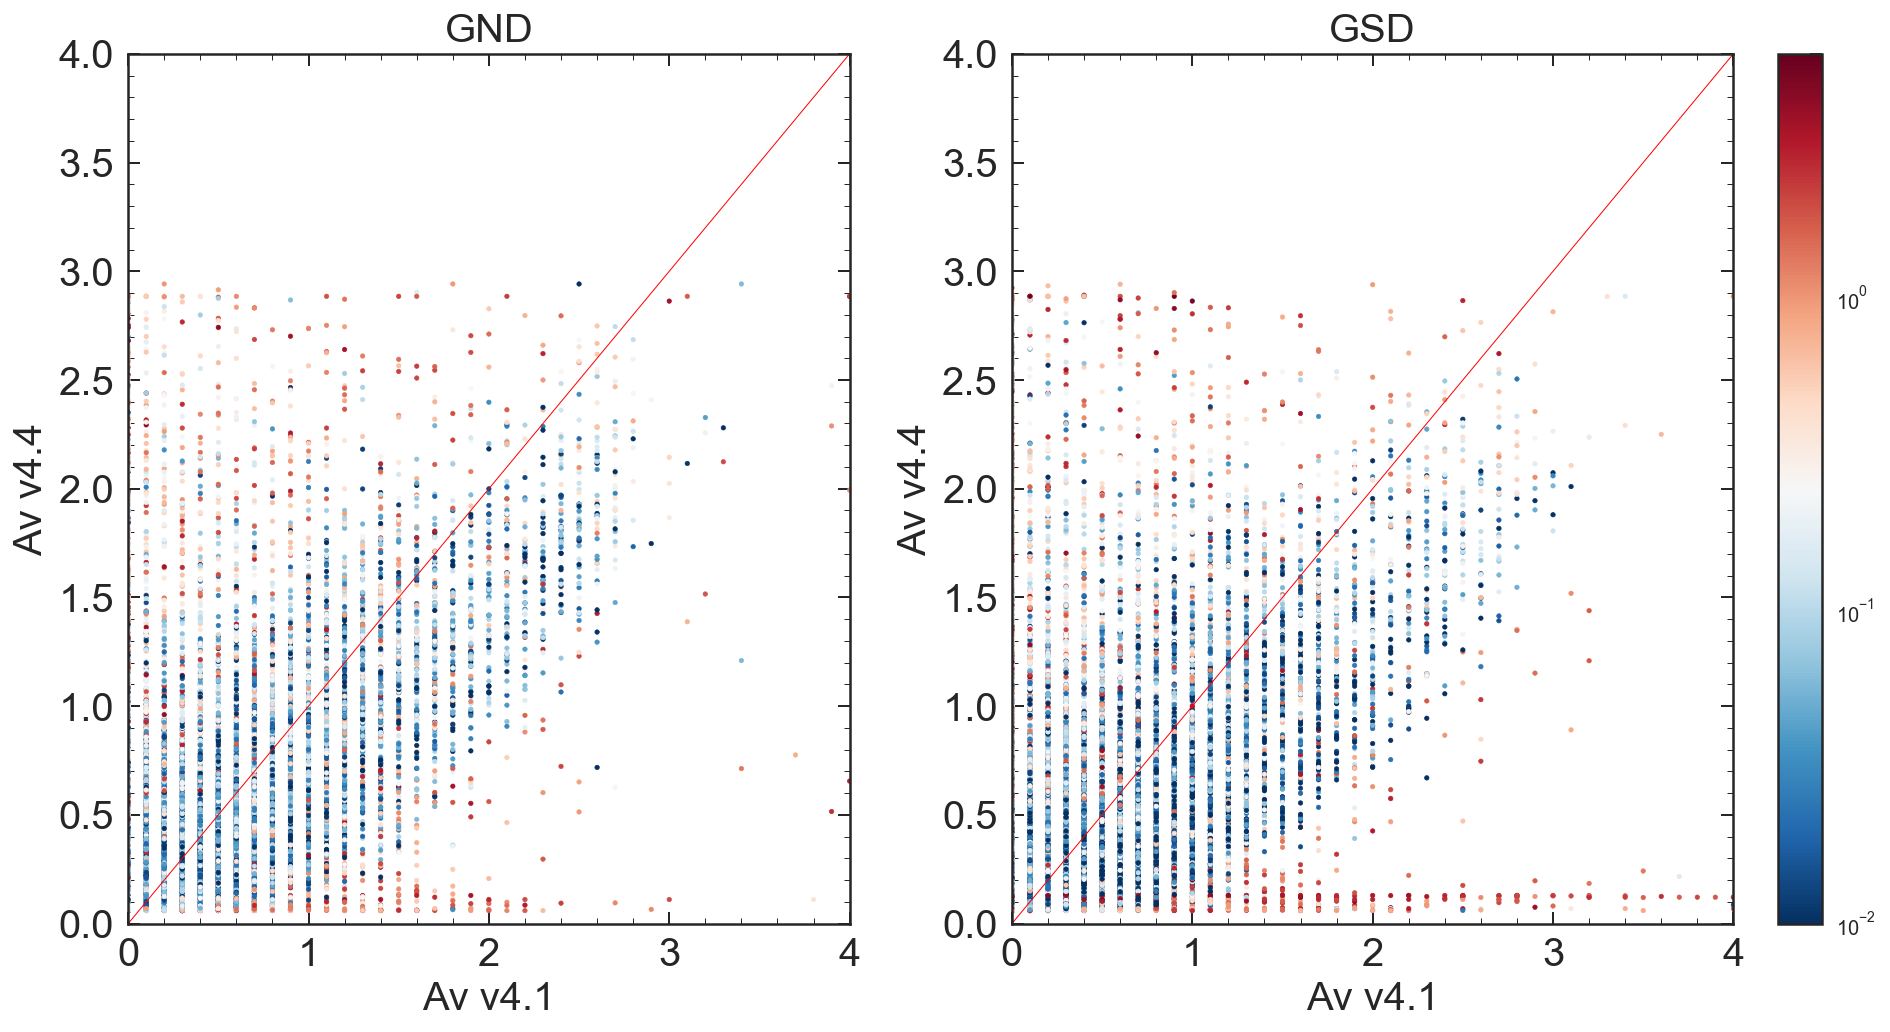

In [59]:
gs = gridspec.GridSpec(1,2, width_ratios=[8,10])

plt.figure(figsize=[16,8])
plt.subplot(gs[0])
plt.scatter(uvjcatN1.query('use == 1 and star < 0.8').Av,uvjcatN4.query('use == 1 and star < 0.8').Av,s=5,
            c=np.abs(np.array(uvjcatN1.query('use == 1 and star < 0.8').z) - np.array(uvjcatN4.query('use == 1 and star < 0.8').z_phot)), 
            norm=colors.LogNorm(vmin=0.01, vmax=6), cmap='RdBu_r')
plt.plot([0,4],[0,4],'r',linewidth = 0.5)
plt.xlabel('Av v4.1', fontsize=20)
plt.ylabel('Av v4.4', fontsize=20)
plt.title('GND', fontsize=20)
plt.ylim(0,4)
plt.xlim(0,4)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.subplot(gs[1])
plt.scatter(uvjcatS1.query('use == 1 and star < 0.8').Av,uvjcatS4.query('use == 1 and star < 0.8').Av,s=5,
            c=np.abs(np.array(uvjcatS1.query('use == 1 and star < 0.8').z) - np.array(uvjcatS4.query('use == 1 and star < 0.8').z_phot)), 
            norm=colors.LogNorm(vmin=0.01, vmax=6), cmap='RdBu_r')

plt.plot([0,4],[0,4],'r',linewidth = 0.5)
plt.xlabel('Av v4.1', fontsize=20)
plt.ylabel('Av v4.4', fontsize=20)
plt.title('GSD', fontsize=20)
plt.ylim(0,4)
plt.xlim(0,4)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar()

In [171]:
np.percentile(res,16),np.percentile(res,50),np.percentile(res,84)

(-0.06262736, -0.008433999999999997, 0.02707296000000001)

In [172]:
res

array([-0.084005,  0.015561, -0.1252  , ...,  0.024615, -0.0965  ,
        5.02477 ])

# $\Sigma_1$ all field

In [33]:
hpath = os.environ['HOME'] + '/'

if hpath.split('/')[-2][-1] == 'a':
    goodss_125 = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_125 = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodss_160 = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f160w.galfit',format='ascii').to_pandas()
    goodsn_160 = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f160w.galfit',format='ascii').to_pandas()
    
else:
    goodss_125 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodsn_125 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
    goodss_160 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.60lfit',format='ascii').to_pandas()
    goodsn_160 = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.60lfit',format='ascii').to_pandas()

In [69]:
def IR_prime(n, Reff, R):
    b = 2*n - (1/3)  
    return R * np.exp(-b * (R / Reff)**(1/n))

def Sigma_1(field, galaxy):
    if field[1] == 'N':
        main_cat = GN_new
        mass = main_cat.query('id == {0}'.format(galaxy)).mass.values[0]
        zphot = main_cat.query('id == {0}'.format(galaxy)).zphot.values[0] 

        if zphot <= 1.5:
            flux = main_cat.query('id == {0}'.format(galaxy)).f125.values[0]
            gfit_cat = goodsn_125
        else:
            flux = main_cat.query('id == {0}'.format(galaxy)).f160.values[0]
            gfit_cat = goodsn_160

    else:
        main_cat = GS_new
        mass = main_cat.query('id == {0}'.format(galaxy)).mass.values[0]
        zphot = main_cat.query('id == {0}'.format(galaxy)).zphot.values[0] 

        if zphot <= 1.5:
            flux = main_cat.query('id == {0}'.format(galaxy)).f125.values[0]
            gfit_cat = goodss_125
        else:
            flux = main_cat.query('id == {0}'.format(galaxy)).f160.values[0]
            gfit_cat = goodss_160


    grow = gfit_cat.query('NUMBER == {0}'.format(galaxy))

    Reff = (grow.re.values[0] * np.sqrt(grow.q.values[0])) * (cosmo.kpc_proper_per_arcmin(zphot).value)/60
    n = grow.n.values[0]
    mgal = grow.mag.values[0]    

    r_range = np.linspace(0,1,1000)
    top = np.trapz(IR_prime(n, Reff, r_range), r_range)

    r_range = np.linspace(0,100,100000)
    bottom = np.trapz(IR_prime(n, Reff, r_range), r_range)   

    Lgal = 10**((mgal + 48.6) / -2.5)   
    Mab = -2.5*np.log10(flux) + 25
    Lez = 10**((Mab + 48.6) / -2.5) 

    return np.log10((top / bottom)*(Lgal / Lez)*mass / np.pi**2)

In [104]:
n_f = []

for i in GS_new.index:
    if GS_new.zphot[i] <= 1.5:
        n_f.append(goodss_125.query('NUMBER == {0}'.format(GS_new.id[i])).f.values[0])
    else:
        n_f.append(goodss_160.query('NUMBER == {0}'.format(GS_new.id[i])).f.values[0])
    
GS_new['n_f'] = n_f

n_f = []

for i in GN_new.index:
    if GN_new.zphot[i] <= 1.5:
        n_f.append(goodsn_125.query('NUMBER == {0}'.format(GN_new.id[i])).f.values[0])
    else:
        n_f.append(goodsn_160.query('NUMBER == {0}'.format(GN_new.id[i])).f.values[0])
    
GN_new['n_f'] = n_f

In [105]:
log_sig1 = []

for i in GS_new.index:
    log_sig1.append(Sigma_1('GSD', GS_new.id[i]))
    
GS_new['log_sig1'] = log_sig1

log_sig1 = []

for i in GN_new.index:
    log_sig1.append(Sigma_1('GND', GN_new.id[i]))
    
GN_new['log_sig1'] = log_sig1

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in sqrt
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars


[10, 8.1, 0.6, 2.6]

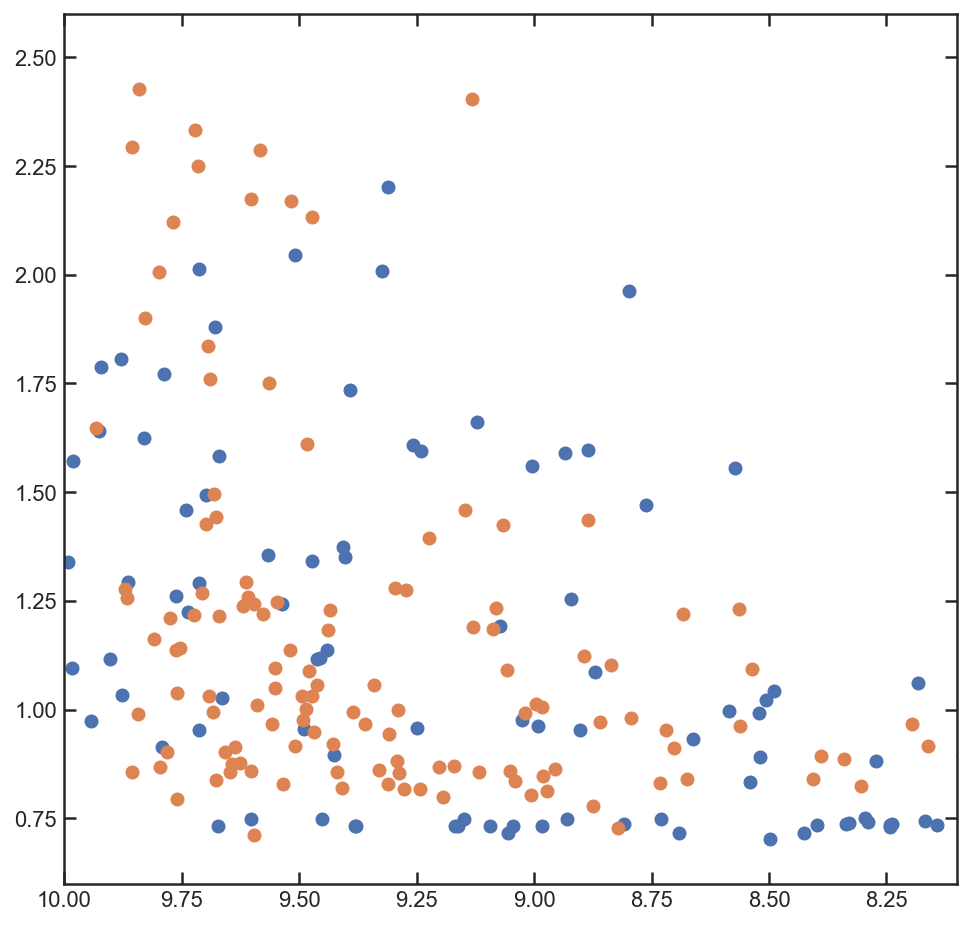

In [109]:
plt.figure(figsize=[8,8])

plt.scatter(GS_new.query('n_f == 0 and zerr < 0.02').log_sig1, GS_new.query('n_f == 0 and zerr < 0.02').zphot)
plt.scatter(GN_new.query('n_f == 0 and zerr < 0.02').log_sig1, GN_new.query('n_f == 0 and zerr < 0.02').zphot)
plt.axis([10,8.1,0.6,2.6])

(3162277660.1683793, 316227766016.83795)

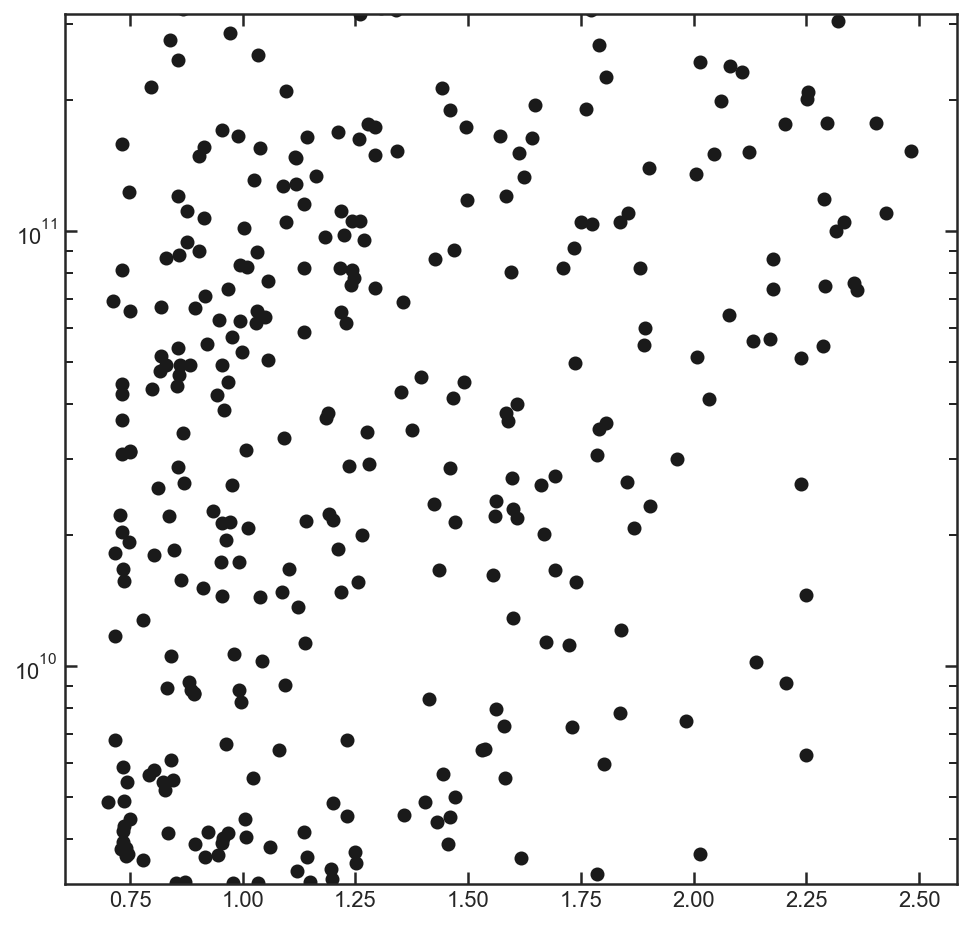

In [118]:
plt.figure(figsize=[8,8])

plt.scatter(GS_new.query('n_f == 0 and zerr < 0.1').zphot,GS_new.query('n_f == 0 and zerr < 0.1').mass,color='k')
plt.scatter( GN_new.query('n_f == 0 and zerr < 0.1').zphot,GN_new.query('n_f == 0 and zerr < 0.1').mass,color='k')
# plt.axis([10,8.1,0.6,2.6])
plt.yscale('log')
plt.ylim(10**9.5,10**11.5)